
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




#### Midé Mabadeje$^{1}$ & Michael Pyrcz$^{1,2}$, University of Texas at Austin

 1. Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering


 2. Department of Geological Sciences, Jackson School of Geosciences


## Comparative Analysis between Our Proposed and Existing Methods

Here's a simple workflow demonstration for educational purposes that can be used for uncertainty exploration, mappings, and analog assignments based on dissimilarity to support decision-making (See read me file for disclaimer).


This workflow comprises these primary methods in sequence:

1. Compute closeology via DBSCAN clustering in high dimensional space, assuming only spatial dependence exists.
2. Perform multivariate analysis on the dataset assuming there is no spatial dependence.
3. Apply the proposed geostatistical spatial-multivariate method for dissimilarity matrix computation that captures both multivariate and spatial dependence in subsurface datasets.
4. Compute the group consistency scores (GCS) and pairwise similarity scores (PSS).

### Getting Started

Here's the steps to get setup in Python with the "package name" from the `requirements.txt` file:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/).
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal.
3. In the terminal type: pip install "package name".
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the "package name" functionality.

After installing these packages let's import them as libraries for our workflow.

### Import Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
from utils import normalizer, ProcessPlots, SubRoutine
from utils import matrix_scatter, gcs, pss_all
from sklearn.manifold import MDS

pio.renderers.default = 'notebook'

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [2]:
# load previously saved files
Dij_SM = np.load('Proposed dissimilarity matrix.npy')
kmap_Eucl = np.load('Kriged response in Euclidean space.npy')
kmap_mds = np.load('krig_response_MDS.npy')

# existing methodology
Dij_S = np.load('Classical Closeology dissimilarity matrix.npy')  # closeology case without weights
Dij_M = np.load('Classical Multivariate dissimilarity matrix.npy')  # multivariate weights without weights

In [3]:
df = pd.read_csv("12_sample_data.csv", usecols=['X', 'Y', 'Porosity', 'Perm', 'AI']) # read a .csv file in as a DataFrame
df = df.sample(n=100, random_state=13, ignore_index=True)

# Closeology

Via Euclidean distance metric for dissimilarity computation in MDS

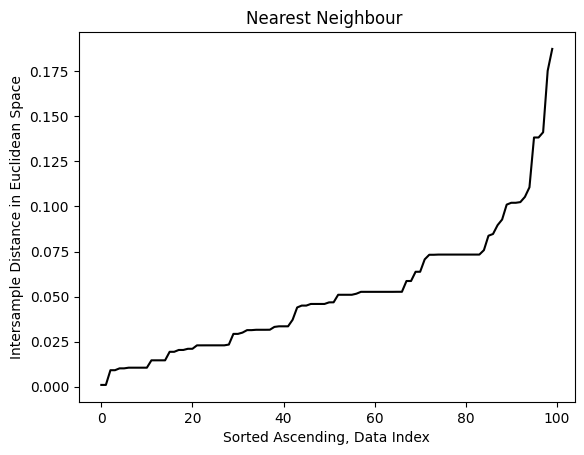

The intersample distance is 0.05127


In [4]:
df_norm_coors = normalizer(df, features=['X', 'Y'], keep_only_norm_features=False)
utility = SubRoutine(
    dataset=df_norm_coors,
    xcoor='NS_X',
    ycoor='NS_Y',
)

lag_distance = utility.nearest_neighbor(space_index=1)

In [5]:
# closeo_routine = SubRoutine(
#     dataset=df_norm_coors, xcoor='NS_X', ycoor='NS_Y'
# )

closeo_routine = SubRoutine(
    dataset=df_norm_coors, xcoor='X', ycoor='Y', normalize=True
)

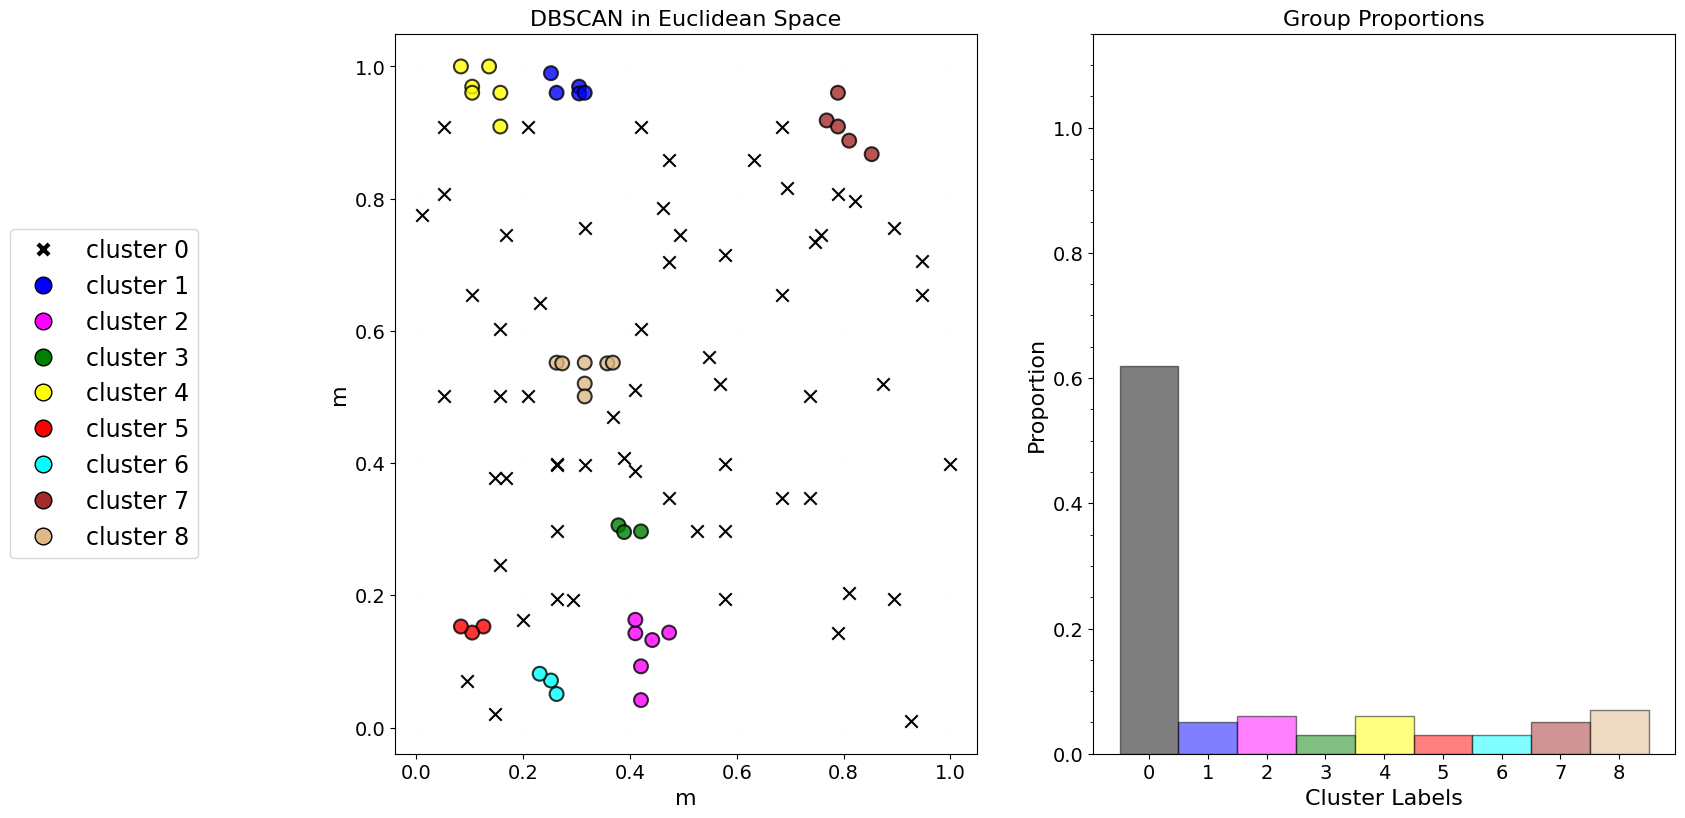

In [6]:
df_cluster, df_outlier, merged_df, number_cluster = closeo_routine.dbscan_plotter(
    eps=lag_distance,
    min_samp=3,
    cluster_label='DB-label',
    xlabel='NS_X',
    ylabel='NS_Y',
    space_index=1,
    palette_=1,
    workflow='closeology',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

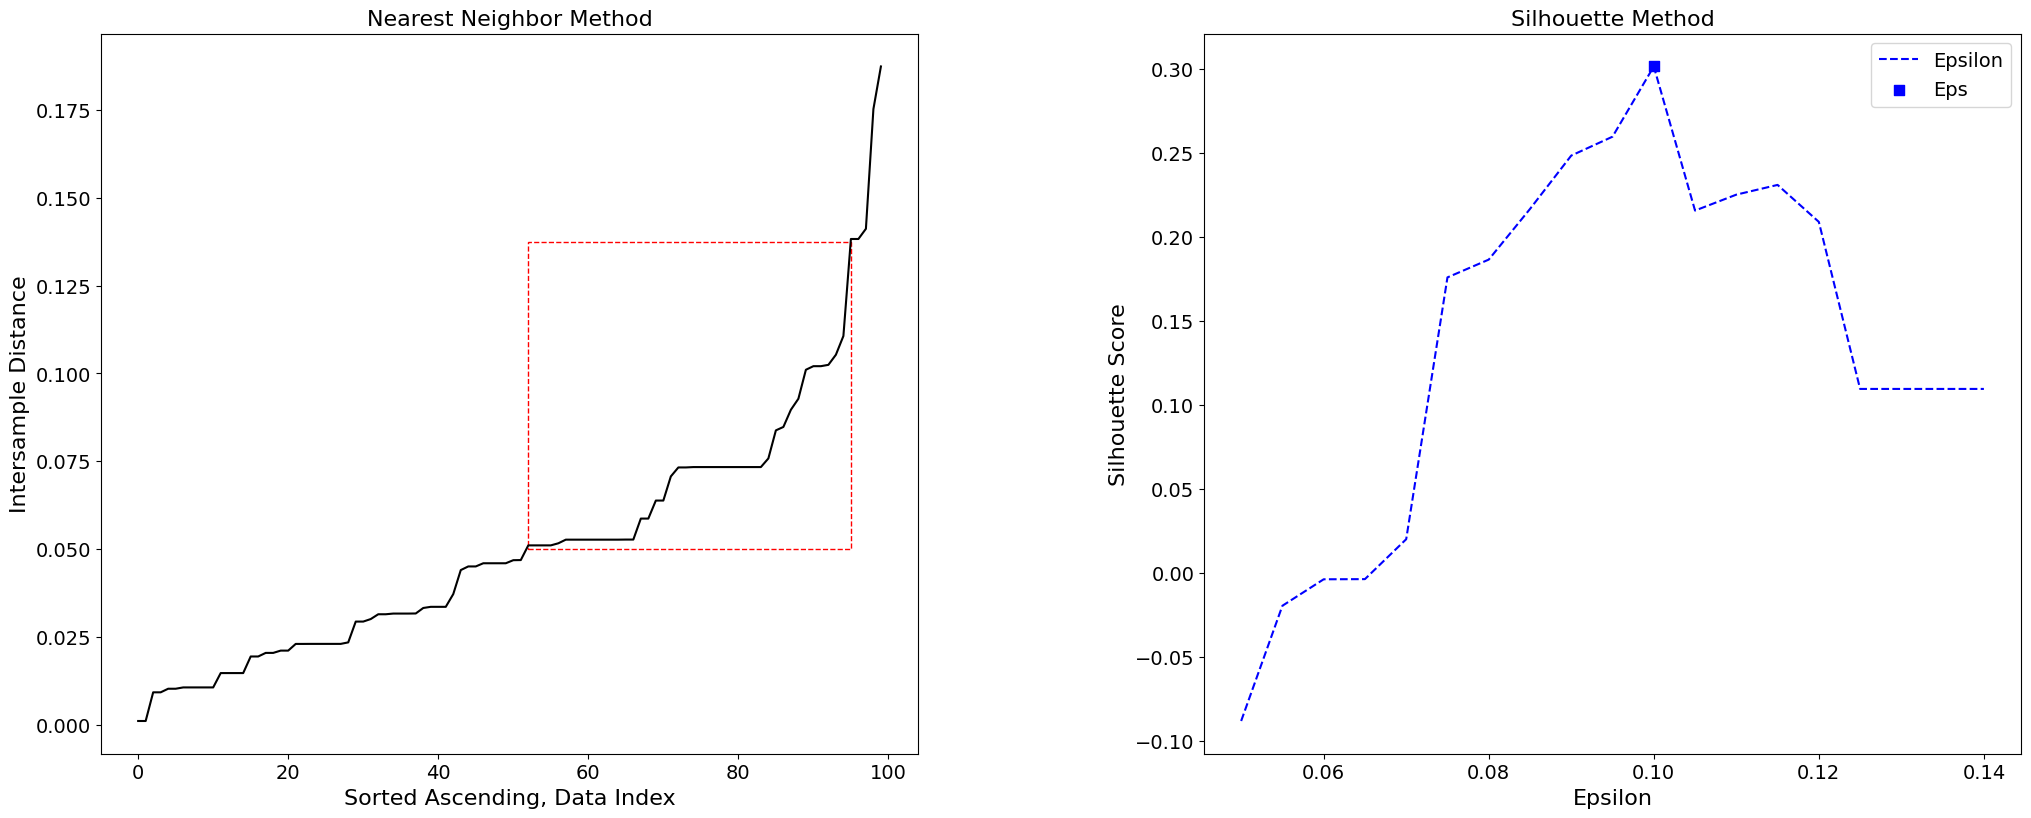

In [7]:
eps, eps_silhouette, min_samples, min_samples2, min_samples_silhouette=closeo_routine.dbscan_tuner(
    min_samp=3,
    start= 0.05,
    stop= 0.1375,
    step= 0.005,
    x= 52,
    y= 0.05,
    x_ext=43,
    y_ext=0.0875
)

In [8]:
df_arranged = df_norm_coors.loc[:,['X', 'Y', 'NS_X', 'NS_Y']]

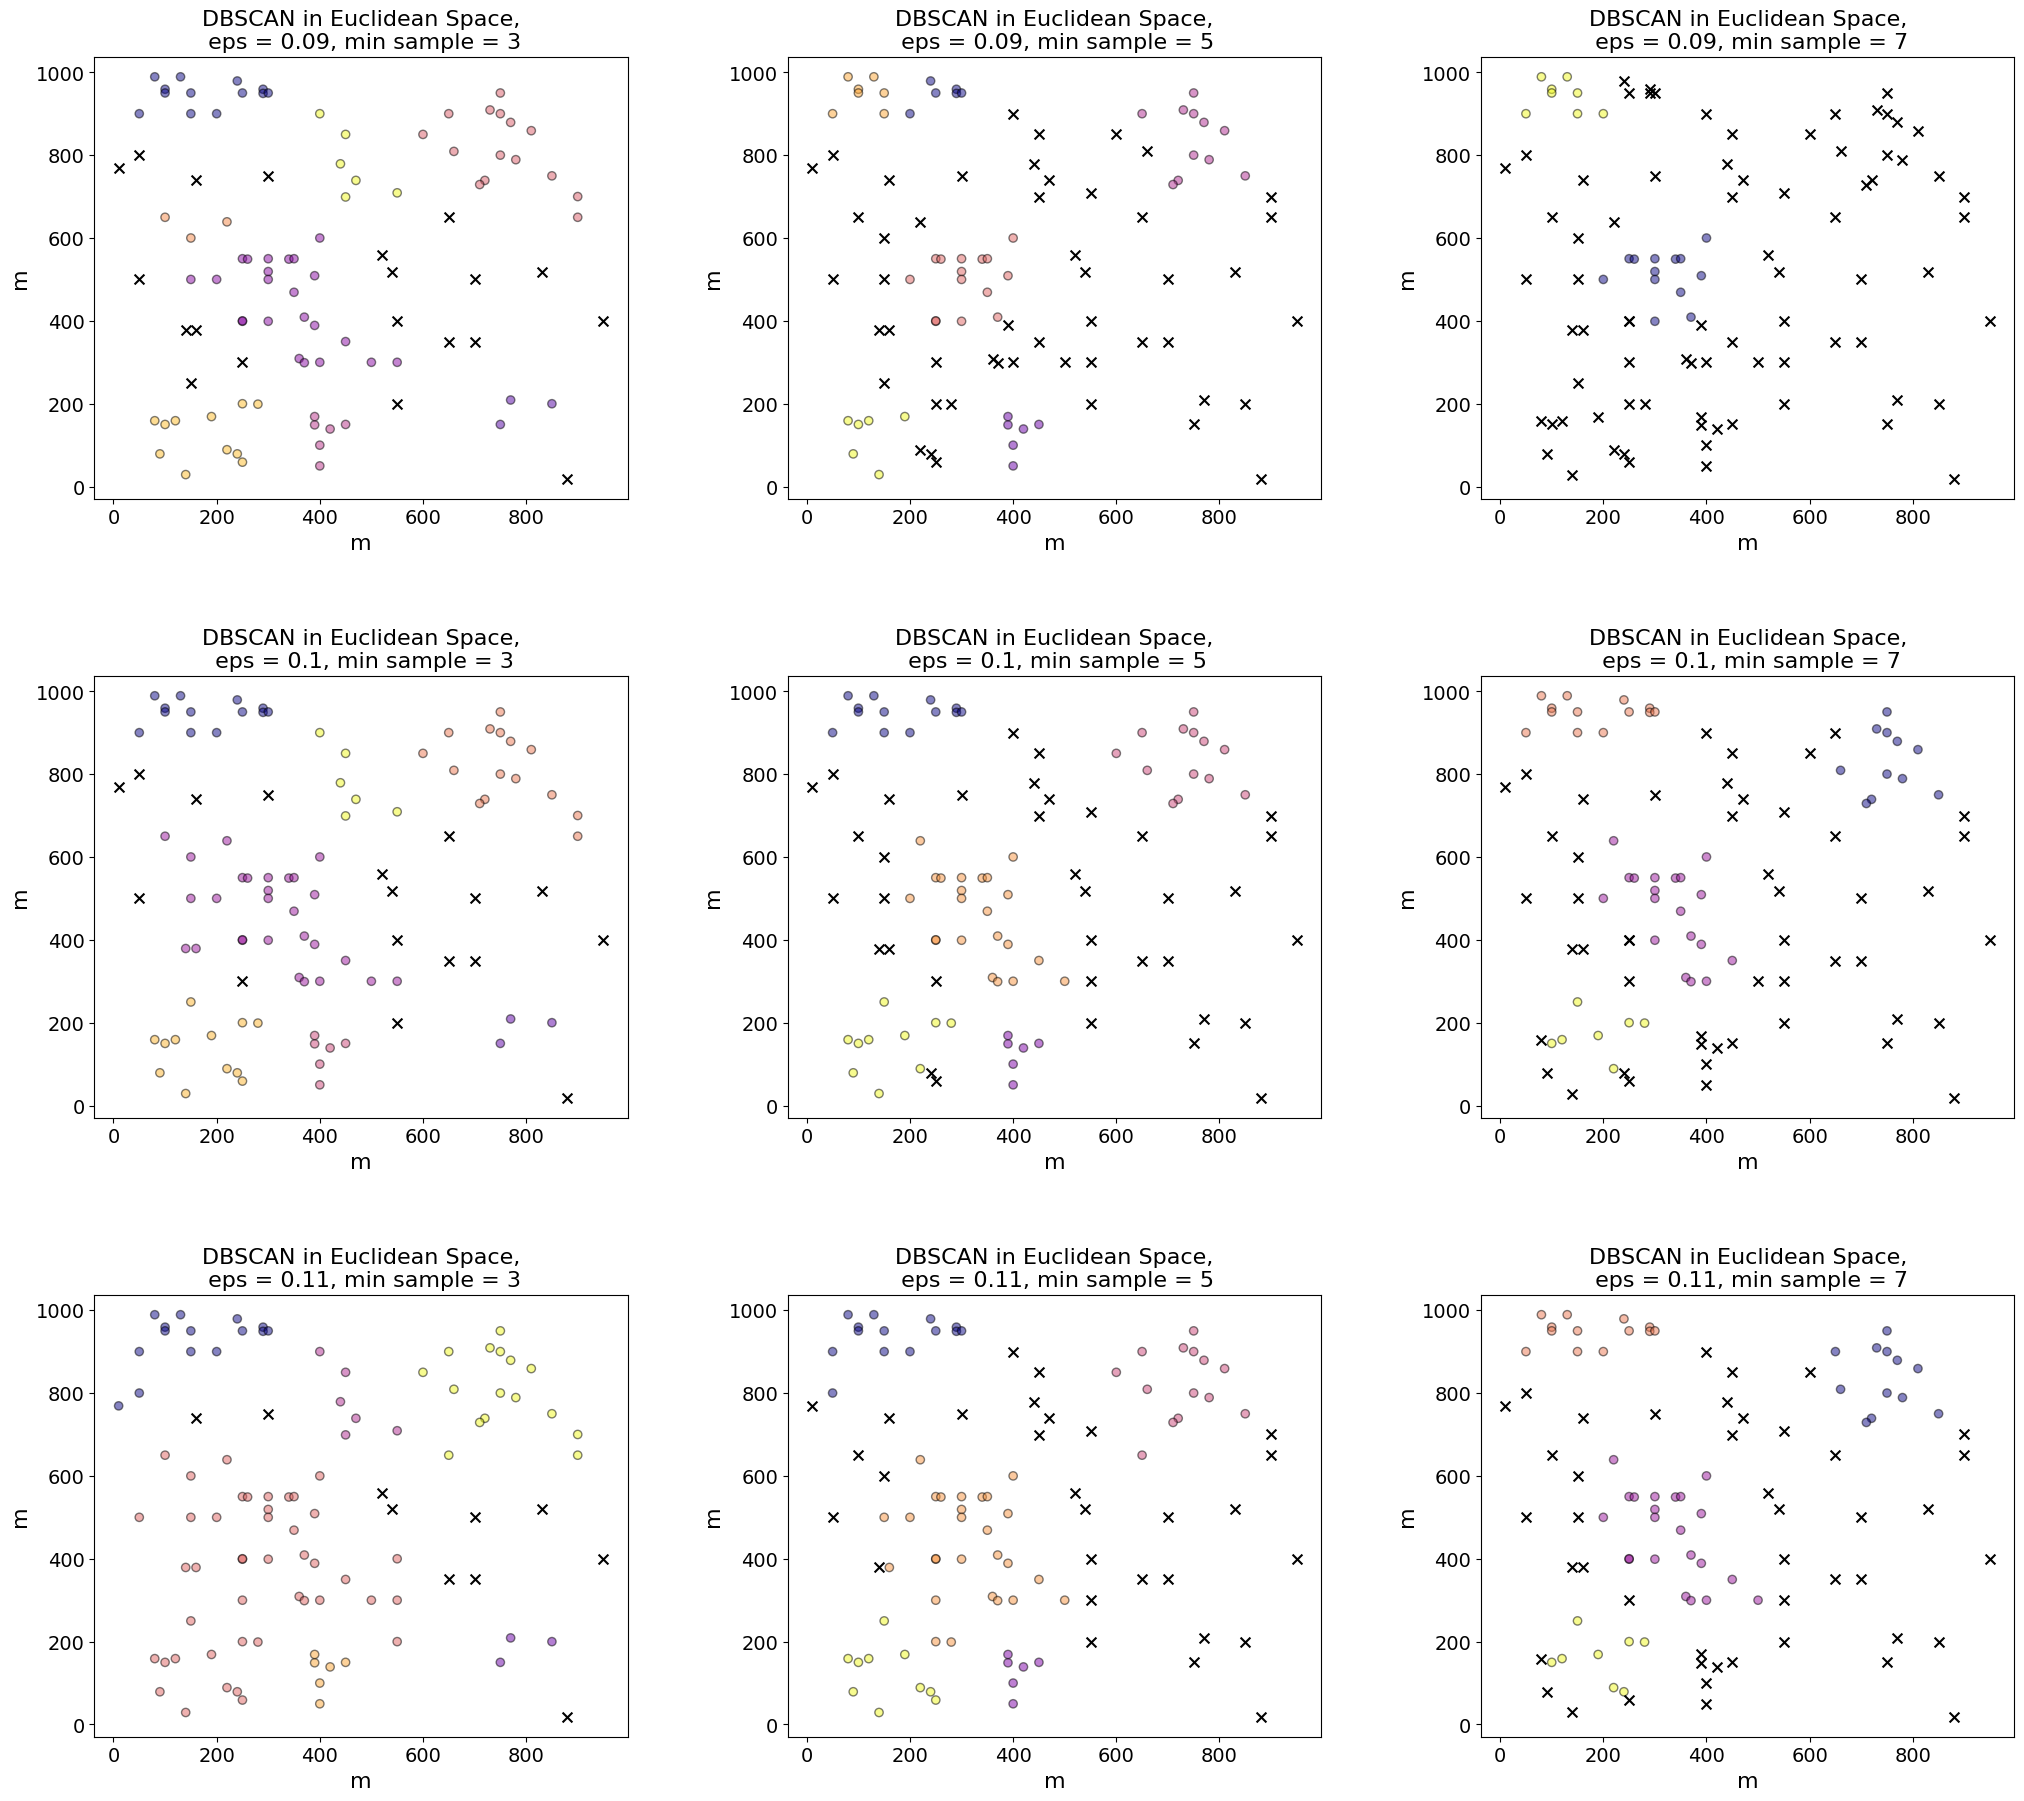

Number of unique clusters in each subplot realization [8, 6, 2, 7, 5, 4, 6, 5, 4]


In [10]:
cluster_nos = closeo_routine.dbscan_sensitivity(
    df=df_arranged,
    eps_mat=[0.09, 0.1, 0.11],
    min_sample_mat=[3,5,7],
    cluster_label='DB-label',
    space_index=1,
    xlabel_units='m',
    ylabel_units='m'
) 

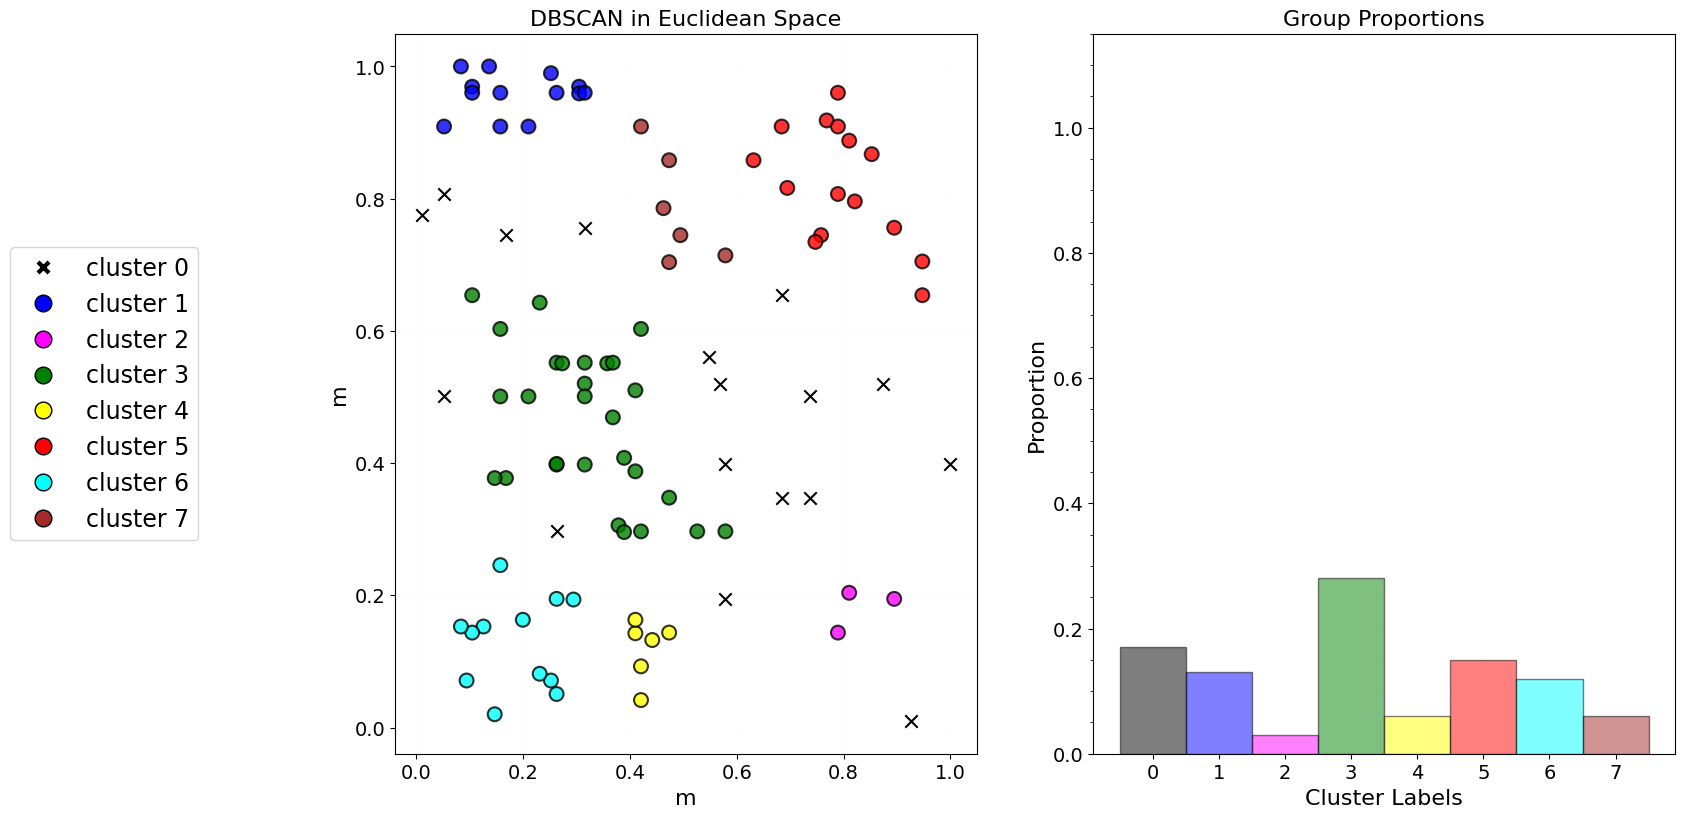

In [11]:
df_cluster, df_outlier, merged_df, number_cluster = closeo_routine.dbscan_plotter(
    eps=eps,
    min_samp=3,
    cluster_label='DB-label',
    xlabel='NS_X',
    ylabel='NS_Y',
    space_index=1,
    palette_=1,
    workflow='closeology',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

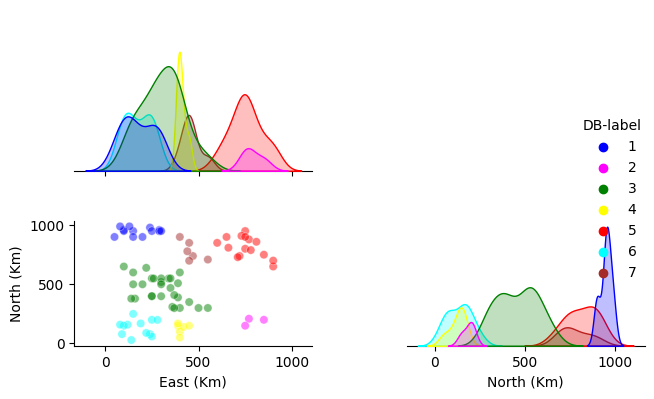

In [12]:
# For main clusters 
df_tuned = df_cluster.copy(deep=True)

df_tuned.rename(columns={'X': 'East (Km)','Y': 'North (Km)'}, inplace=True)


matrix_scatter(df_tuned, ['East (Km)','North (Km)'], 0., 0., 1., 0.6, 0.4, 0.4, 
                  'Matrix Scatterplot by Cluster in Euclidean Space', 1, hue_='DB-label')

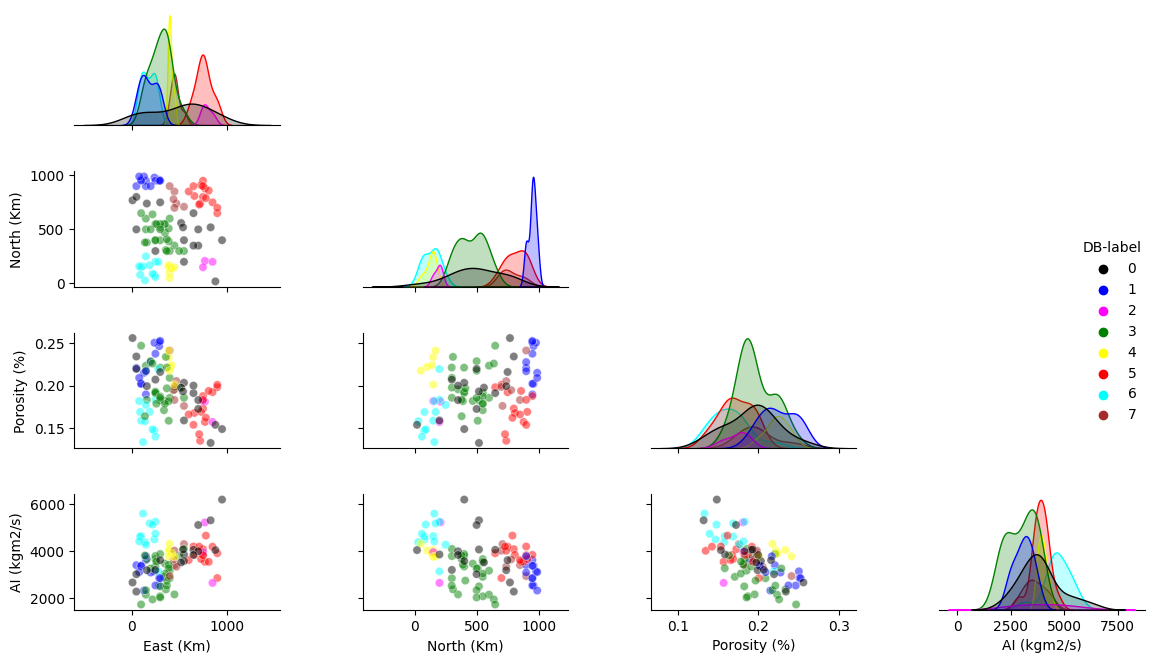

In [13]:
merged_df.rename(columns={'X': 'East (Km)','Y': 'North (Km)',
                       'Porosity': 'Porosity (%)','AI': 'AI (kgm2/s)'}, inplace=True)

matrix_scatter(merged_df, ['East (Km)','North (Km)','Porosity (%)','AI (kgm2/s)'], 0., 0., 1., 0.6, 0.4, 0.4, 
                  'Matrix Scatterplot by Cluster', 1, hue_='DB-label',)

# Multivariate Analysis


Via Mahalanobis distance metric for dissimilarity computation in MDS

In [14]:
df_predictors = df[['X','Y','Porosity', 'AI']].copy()
df_predictors = normalizer(dataset=df_predictors, features=['Porosity', 'AI'])

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/Publications/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



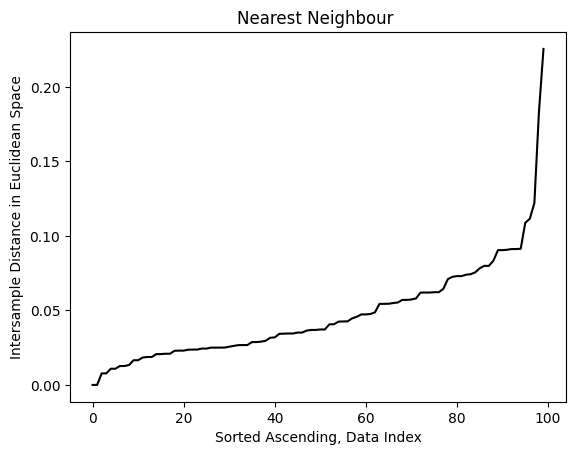

The intersample distance is 0.04740


In [15]:
model_input = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
model_output = model_input.fit_transform(Dij_M)

df_predictors['MDS 1'] = model_output[:, 0]
df_predictors['MDS 2'] = model_output[:, 1]


#normalize mds 1 and 2 
df_predictors = normalizer(dataset=df_predictors, features=['MDS 1', 'MDS 2'])

mds_multi = SubRoutine(df_predictors, 'NS_MDS 1', 'NS_MDS 2')
lag_dist = mds_multi.nearest_neighbor(space_index= 1)

In [16]:
multi_routine = SubRoutine(
    dataset=df_predictors, xcoor='NS_MDS 1', ycoor='NS_MDS 2', normalize=True
)

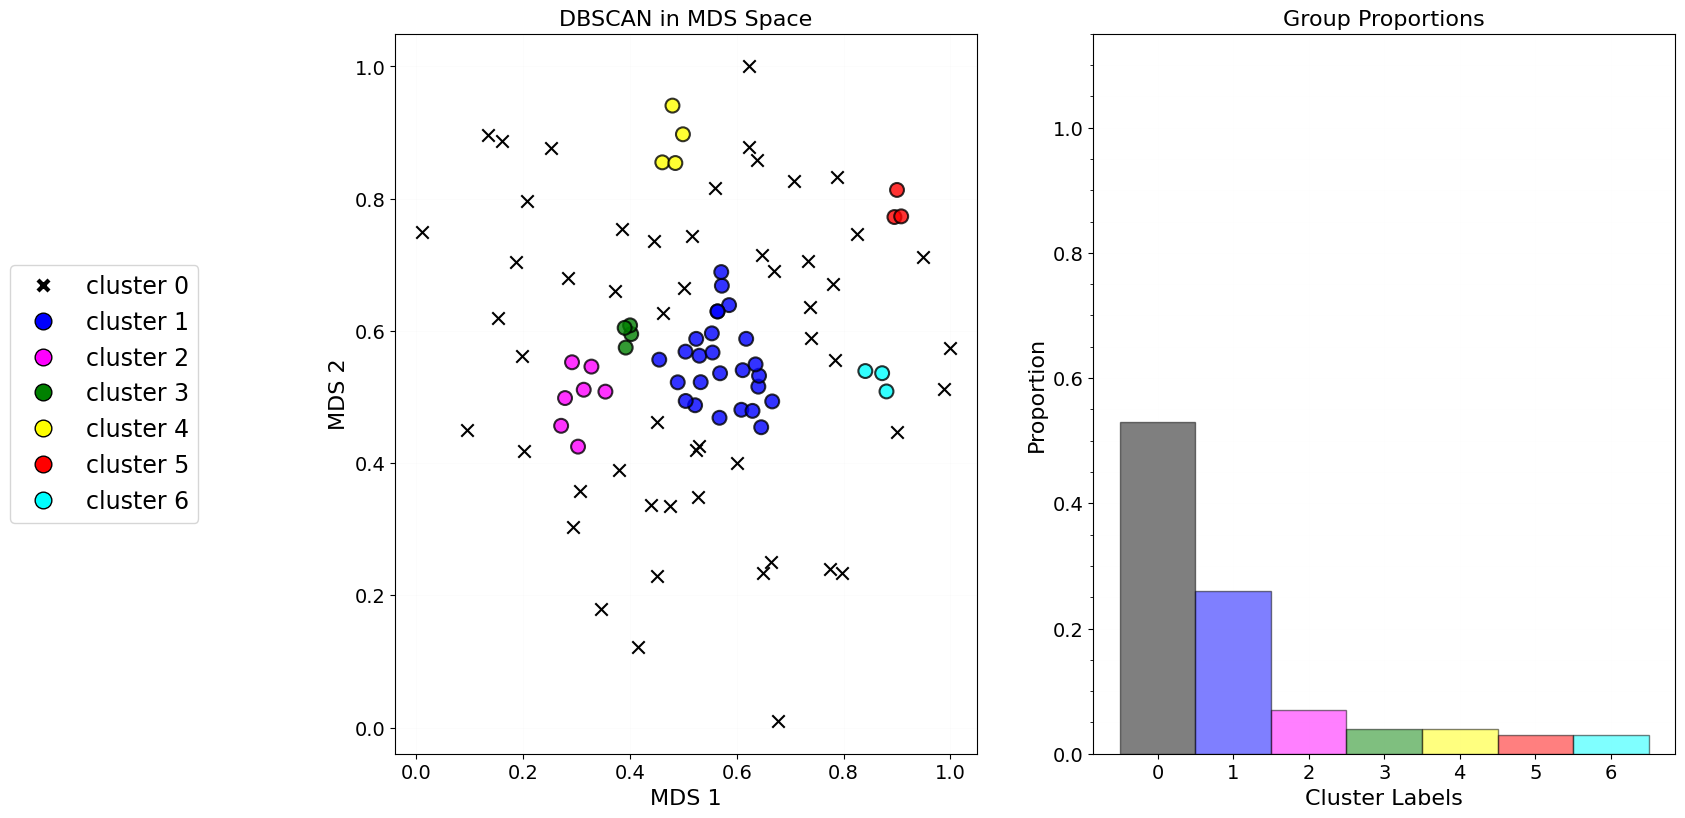

In [17]:
df_cluster_m, df_outlier_m, merged_df_m, number_cluster_m = multi_routine.dbscan_plotter(
    eps=lag_distance,
    min_samp=3,
    cluster_label='DB-label',
    xlabel='NS_MDS 1',
    ylabel='NS_MDS 2',
    space_index=3,
    palette_=1,
    workflow='multivariate',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

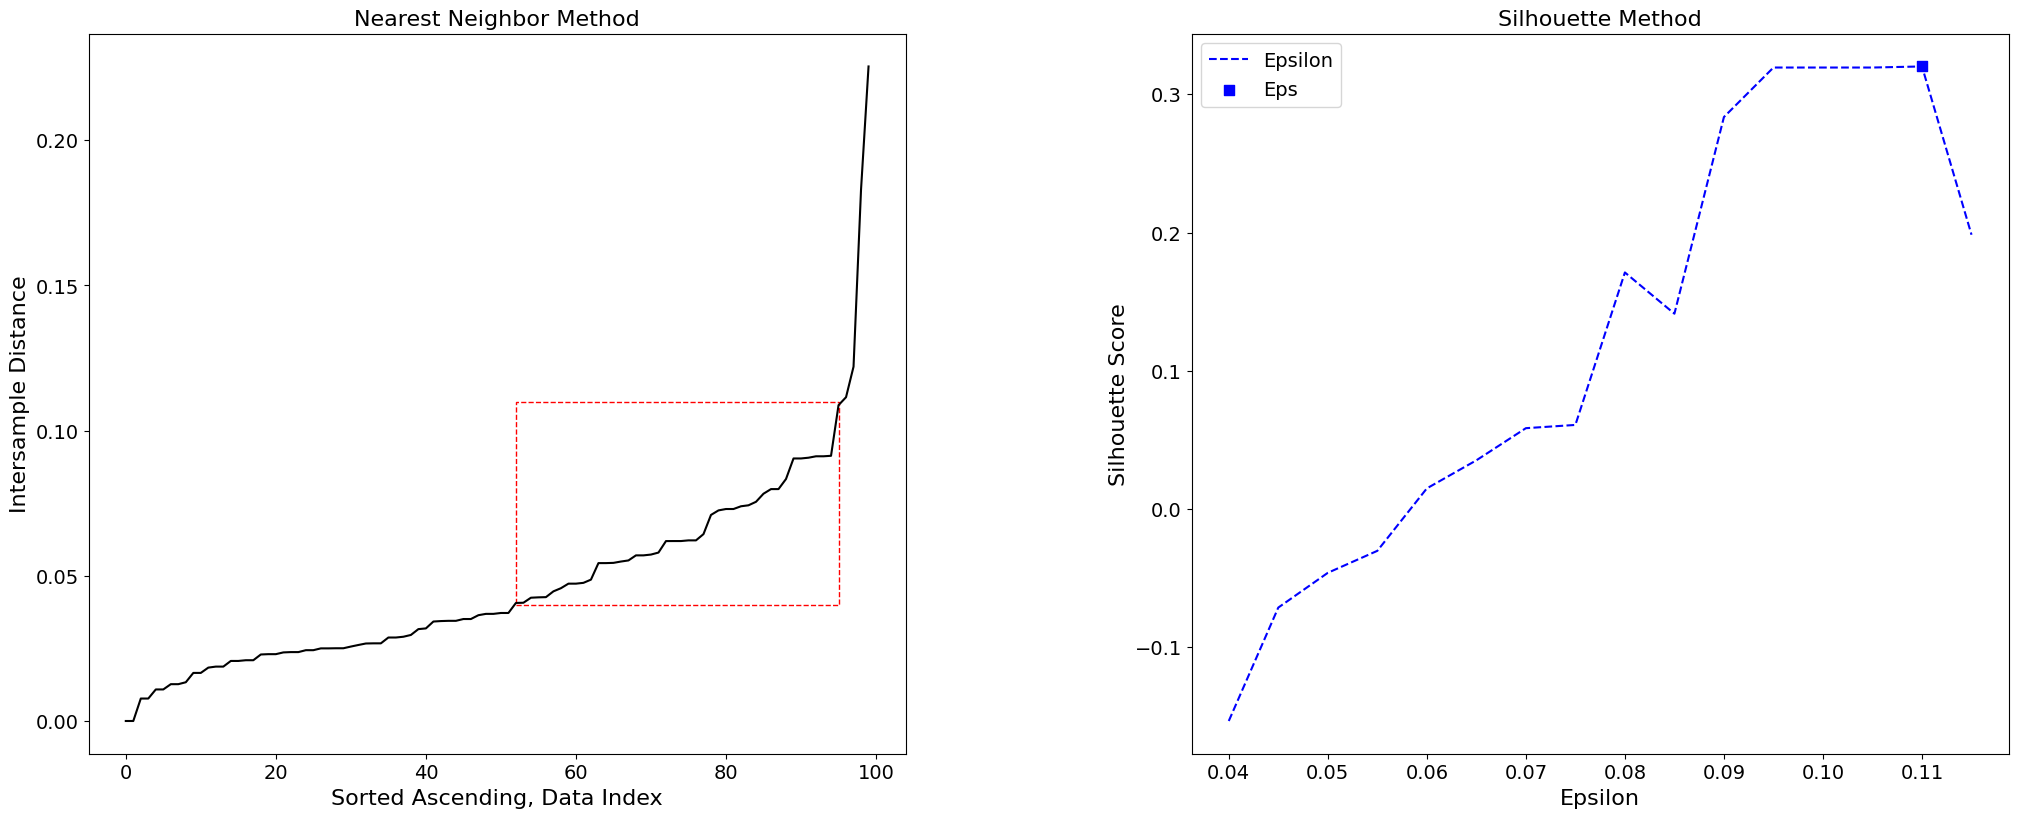

In [18]:
eps_m , eps_silhouette_m , min_samples_m , min_samples2_m , min_samples_silhouette_m = multi_routine.dbscan_tuner(
    min_samp=3,
    start= 0.04,
    stop= 0.11,
    step= 0.005,
    x= 52,
    y= 0.04,
    x_ext= 43,
    y_ext=0.07
)

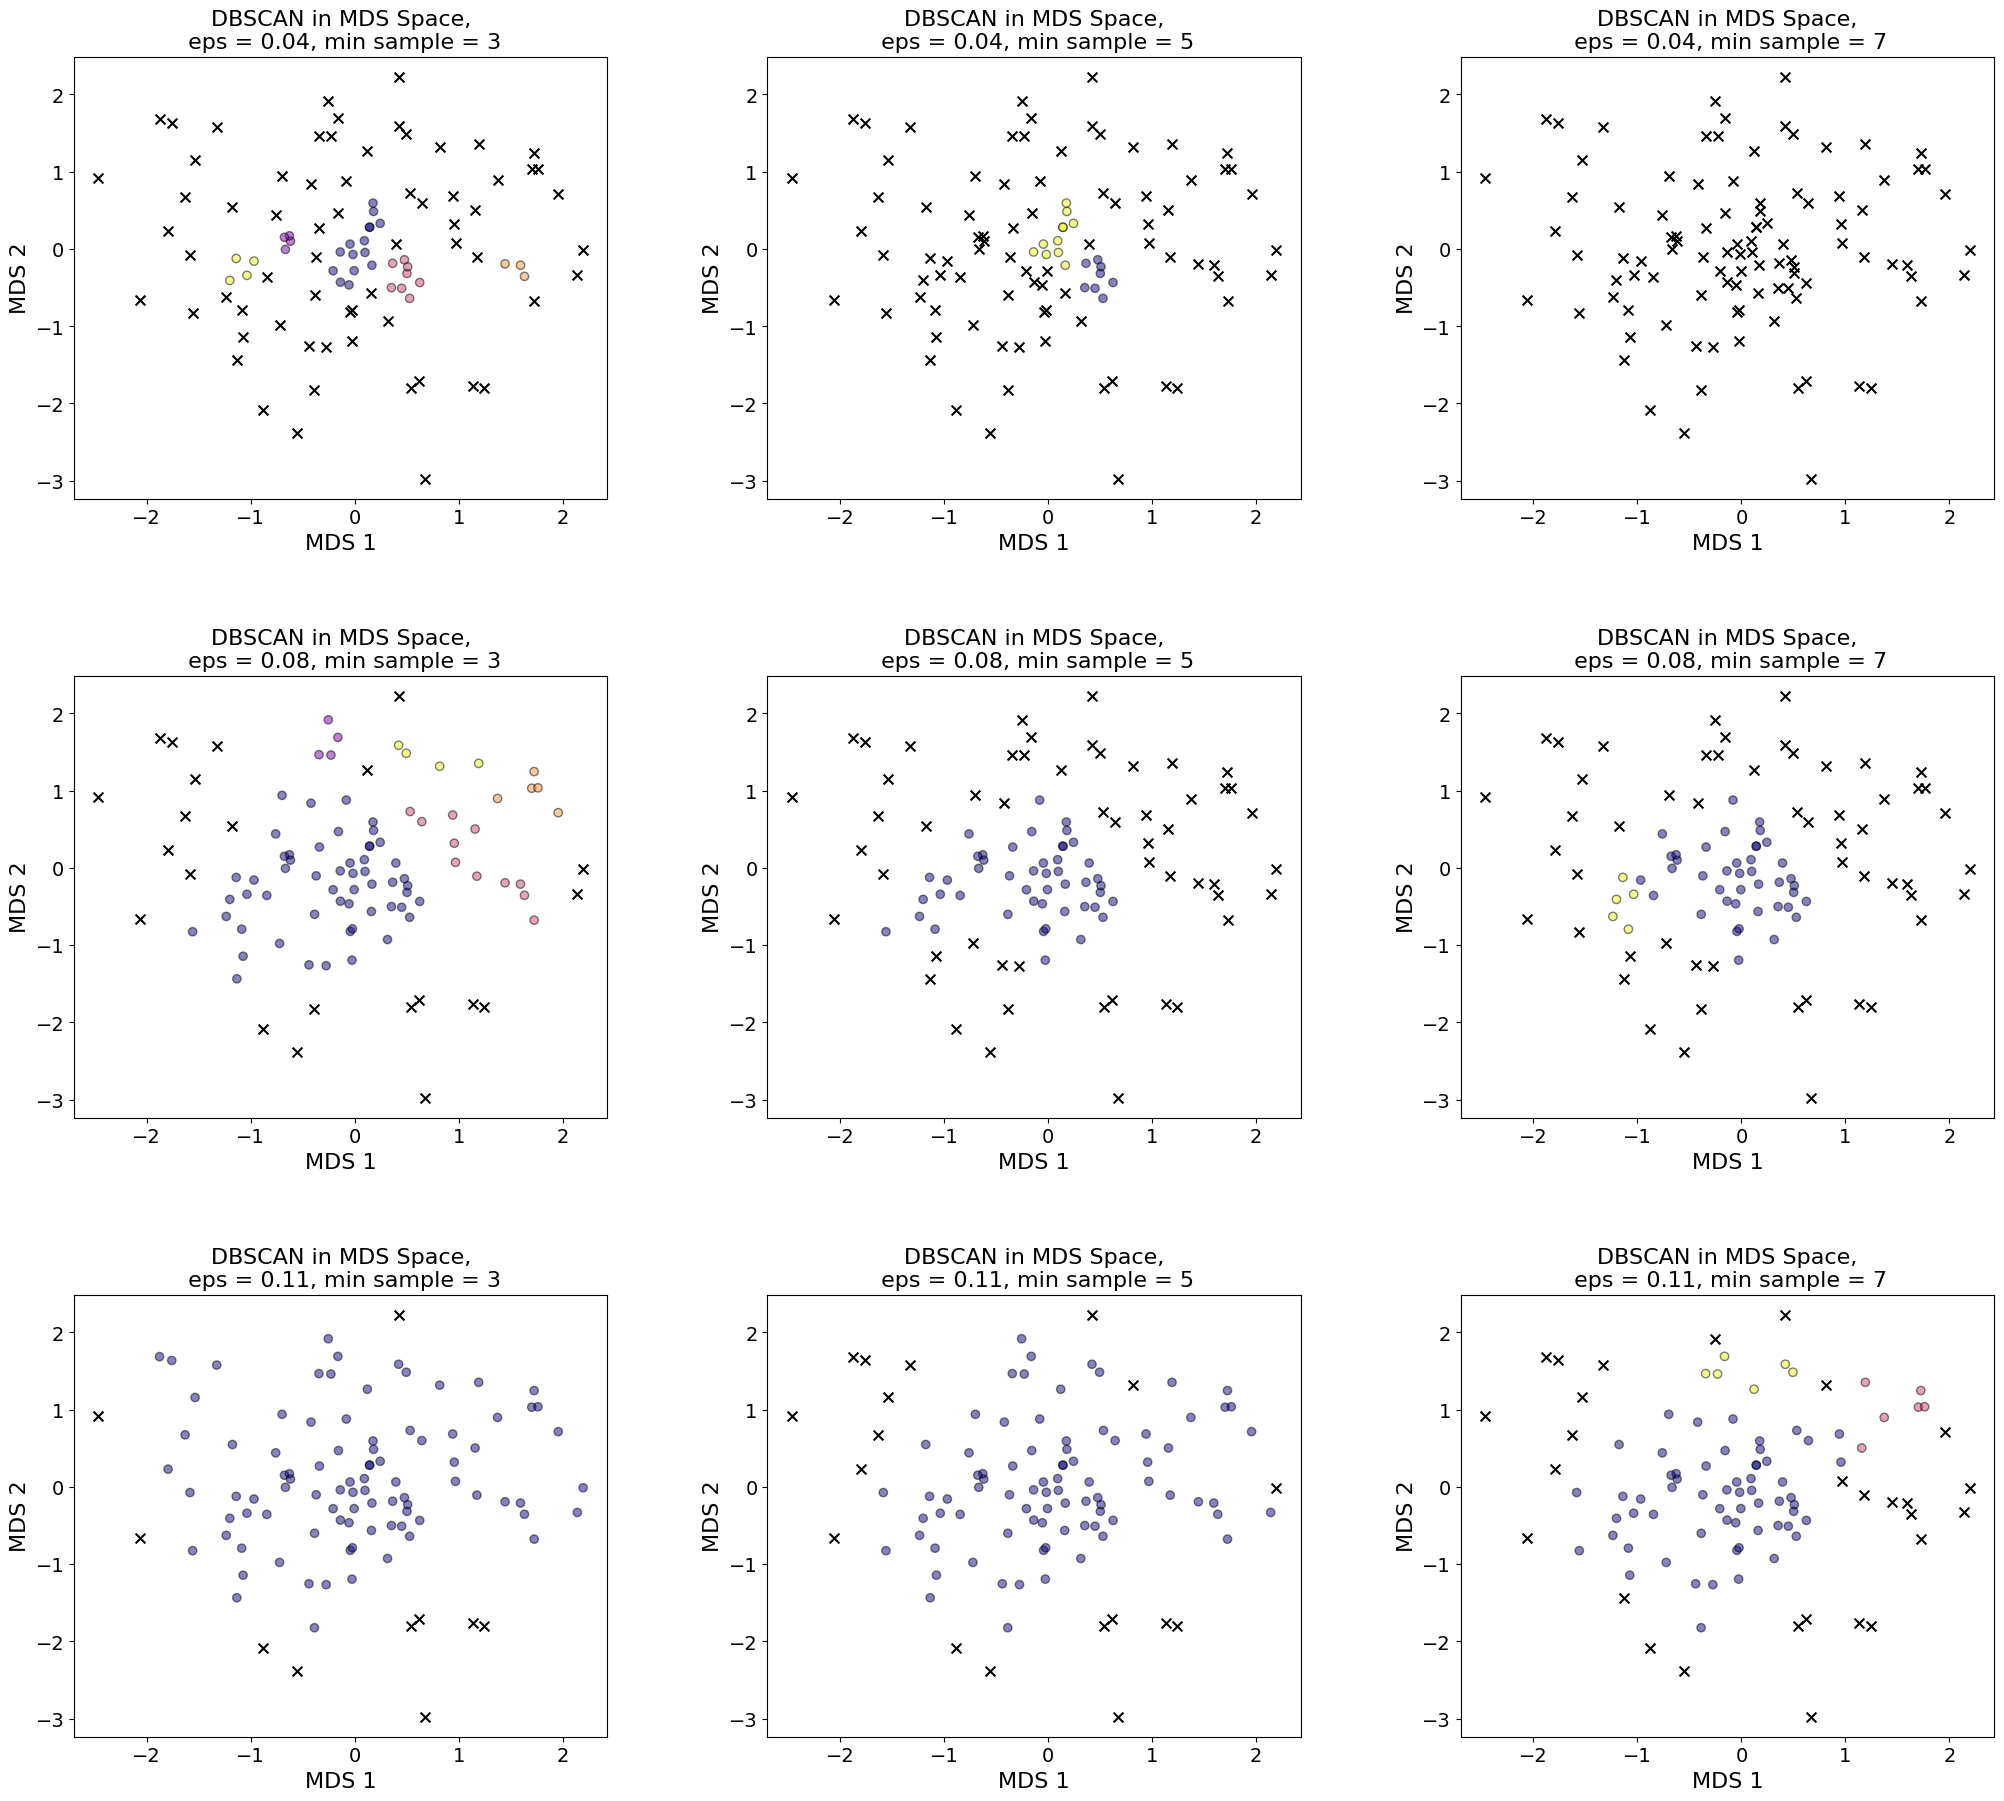

Number of unique clusters in each subplot realization [5, 2, 0, 5, 1, 2, 1, 1, 3]


In [19]:
df_arranged_multi = df_predictors.loc[:,['MDS 1', 'MDS 2', 'NS_MDS 1', 'NS_MDS 2']]

cluster_no_multi = multi_routine.dbscan_sensitivity(
    df=df_arranged_multi,
    eps_mat=[0.04, 0.08 , 0.11],
    min_sample_mat=[3,5,7],
    cluster_label='DB-label',
    space_index=3,
    xlabel_units='m',
    ylabel_units='m'
) 

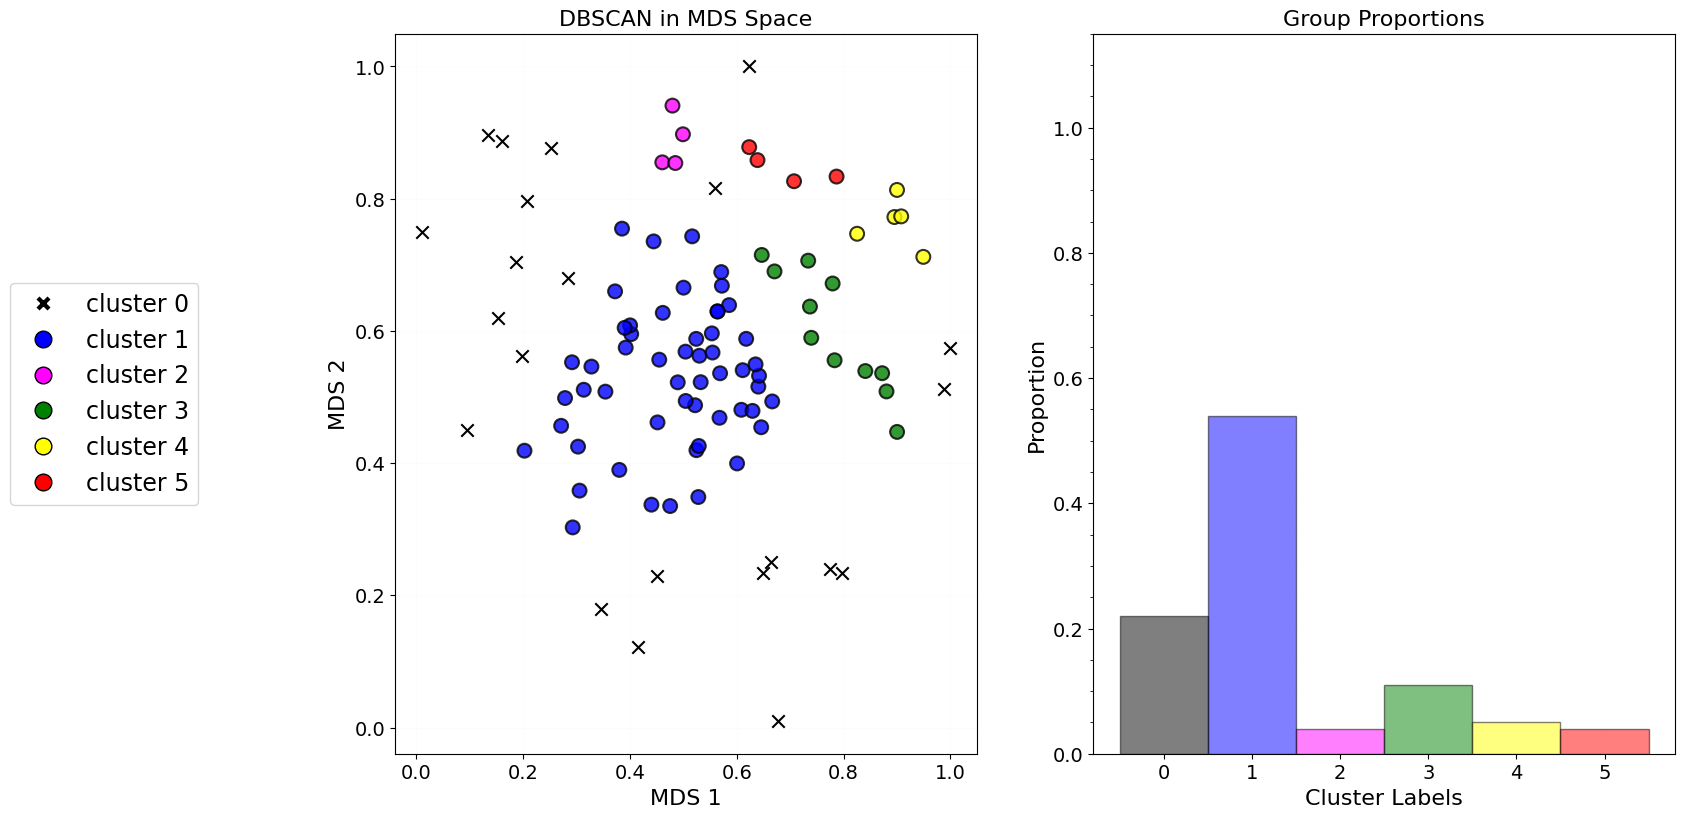

In [20]:
df_cluster_multi, df_outlier_multi, merged_df_multi, number_cluster_multi = multi_routine.dbscan_plotter(
    eps=0.08,
    min_samp=3,
    cluster_label='DB-label',
    xlabel='NS_MDS 1',
    ylabel='NS_MDS 2',
    space_index=3,
    palette_=1,
    workflow='multivariate',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

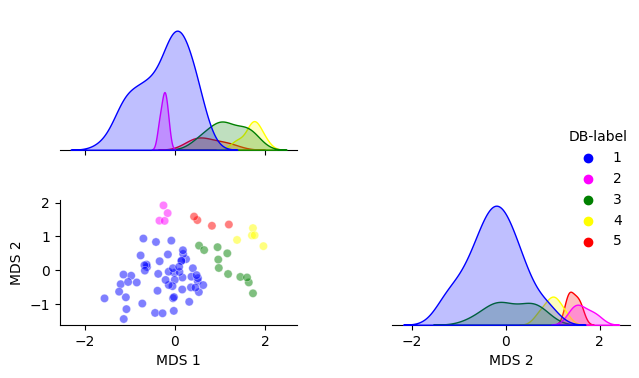

In [21]:
# For main clusters 
df_tuned_multi = df_cluster_multi.copy(deep=True)

matrix_scatter(
    dataframe=df_tuned_multi,
    feat_title=['MDS 1','MDS 2'],
    left_adj=0.,
    bottom_adj=0.,
    right_adj=1.,
    top_adj=0.6,
    wspace=0.4,
    hspace=0.4,
    title='Matrix Scatterplot by Cluster in MDS Space',
    palette_=1, 
    hue_='DB-label'
)

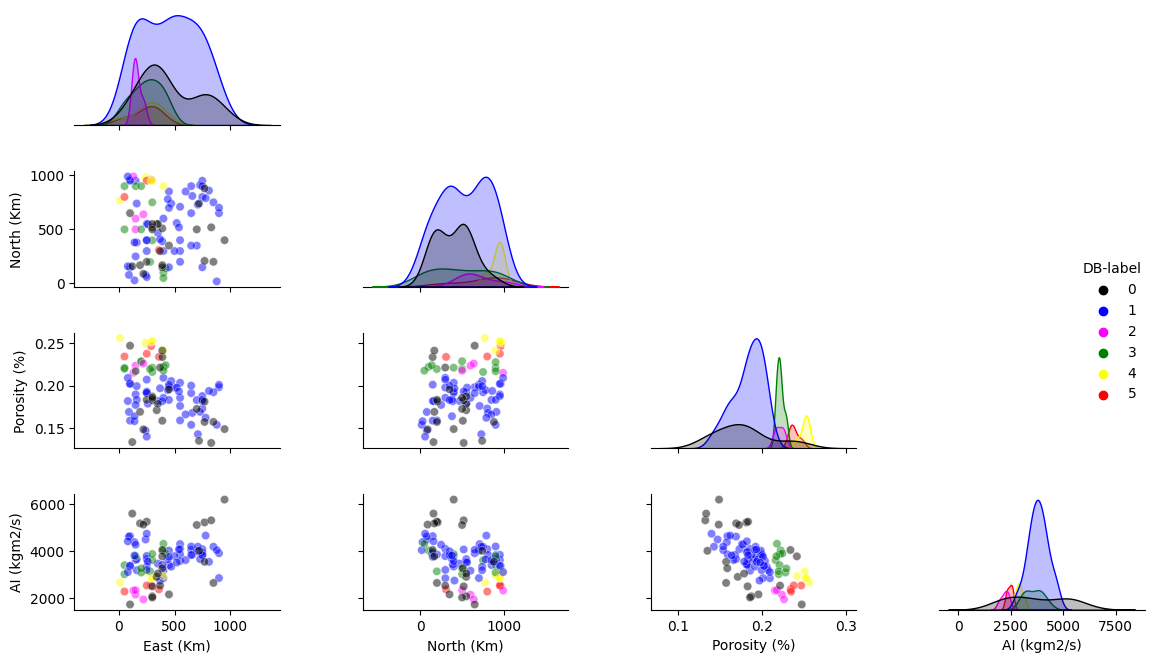

In [22]:
merged_df_multi.rename(columns={'X': 'East (Km)','Y': 'North (Km)',
                       'Porosity': 'Porosity (%)','AI': 'AI (kgm2/s)'}, inplace=True)

matrix_scatter(merged_df_multi, ['East (Km)','North (Km)','Porosity (%)','AI (kgm2/s)'], 0., 0., 1., 0.6, 0.4, 0.4, 
                  'Matrix Scatterplot by Cluster', 1, hue_='DB-label',)

In [23]:
multi_plots = ProcessPlots(
    df=df,
    kriging_response_euclidean=kmap_Eucl,
    kriging_response_mds=kmap_mds
)

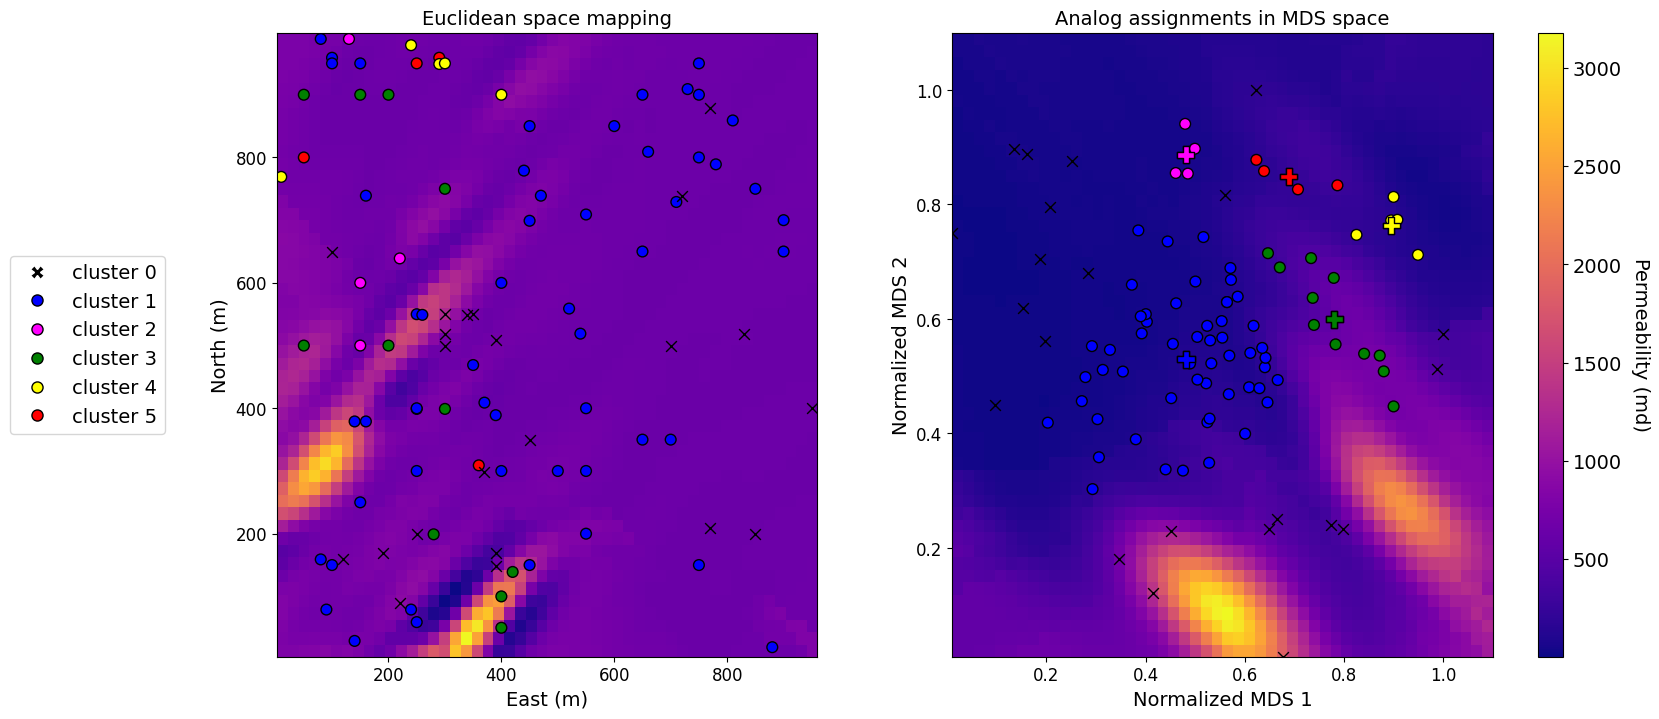

In [24]:
multi_plots.analog_maps(
    cluster=[df_cluster_multi, df_cluster_multi],
    outlier=[df_outlier_multi, df_outlier_multi],
    X=['X', 'NS_MDS 1'],
    Y=['Y', 'NS_MDS 2'],
    T=['Euclidean space mapping', 'Analog assignments in MDS space'],
    cluster_label='DB-label',
    x_labels=['East (m)', 'Normalized MDS 1'],
    y_labels=['North (m)', 'Normalized MDS 2'],
    cb_title='Permeability (md)',
    palette_=1,
    workflow='multivariate',
    cmap='plasma',
    test=False,
    save=False,
    offset_eucl_x=(0.2, 1.01),
    offset_eucl_y=(0.2, 1.01),
    offset_mds_x=(1, 1.1),  # for MDS, consider negatives values present in range
    offset_mds_y=(1, 1.1)   # for MDS, consider negatives values present in range
)

# Our Proposed SpatiaL-Multivariate method

Via geostatistically modified combination of Euclidean and Mahalanobis distance metrics for dissimilarity matrix computation in MDS.

In [25]:
df_proposed = df[['X','Y','Porosity', 'AI']].copy()
df_proposed = normalizer(dataset=df_proposed, features=['Porosity', 'AI'])

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/Publications/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



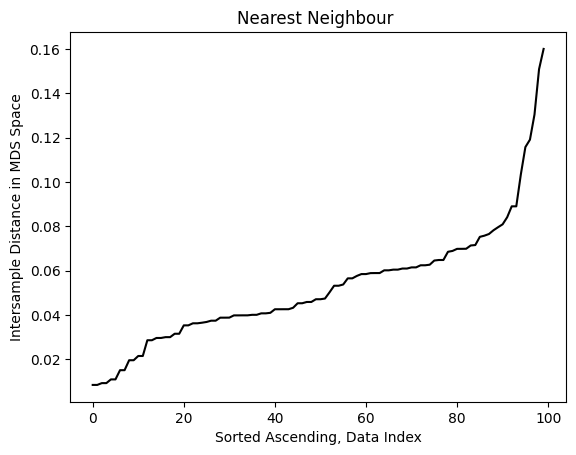

The intersample distance is 0.05250


In [26]:
model_input = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
model_output = model_input.fit_transform(Dij_SM)

df_proposed['MDS 1'] = model_output[:, 0]
df_proposed['MDS 2'] = model_output[:, 1]


#normalize mds 1 and 2 
df_proposed = normalizer(dataset=df_proposed, features=['MDS 1', 'MDS 2'])

mds_proposed = SubRoutine(df_proposed, 'NS_MDS 1', 'NS_MDS 2')
lag_dist = mds_proposed.nearest_neighbor(space_index= 3)

In [27]:
proposed_routine = SubRoutine(
    dataset=df_proposed, xcoor='NS_MDS 1', ycoor='NS_MDS 2', normalize=True
)

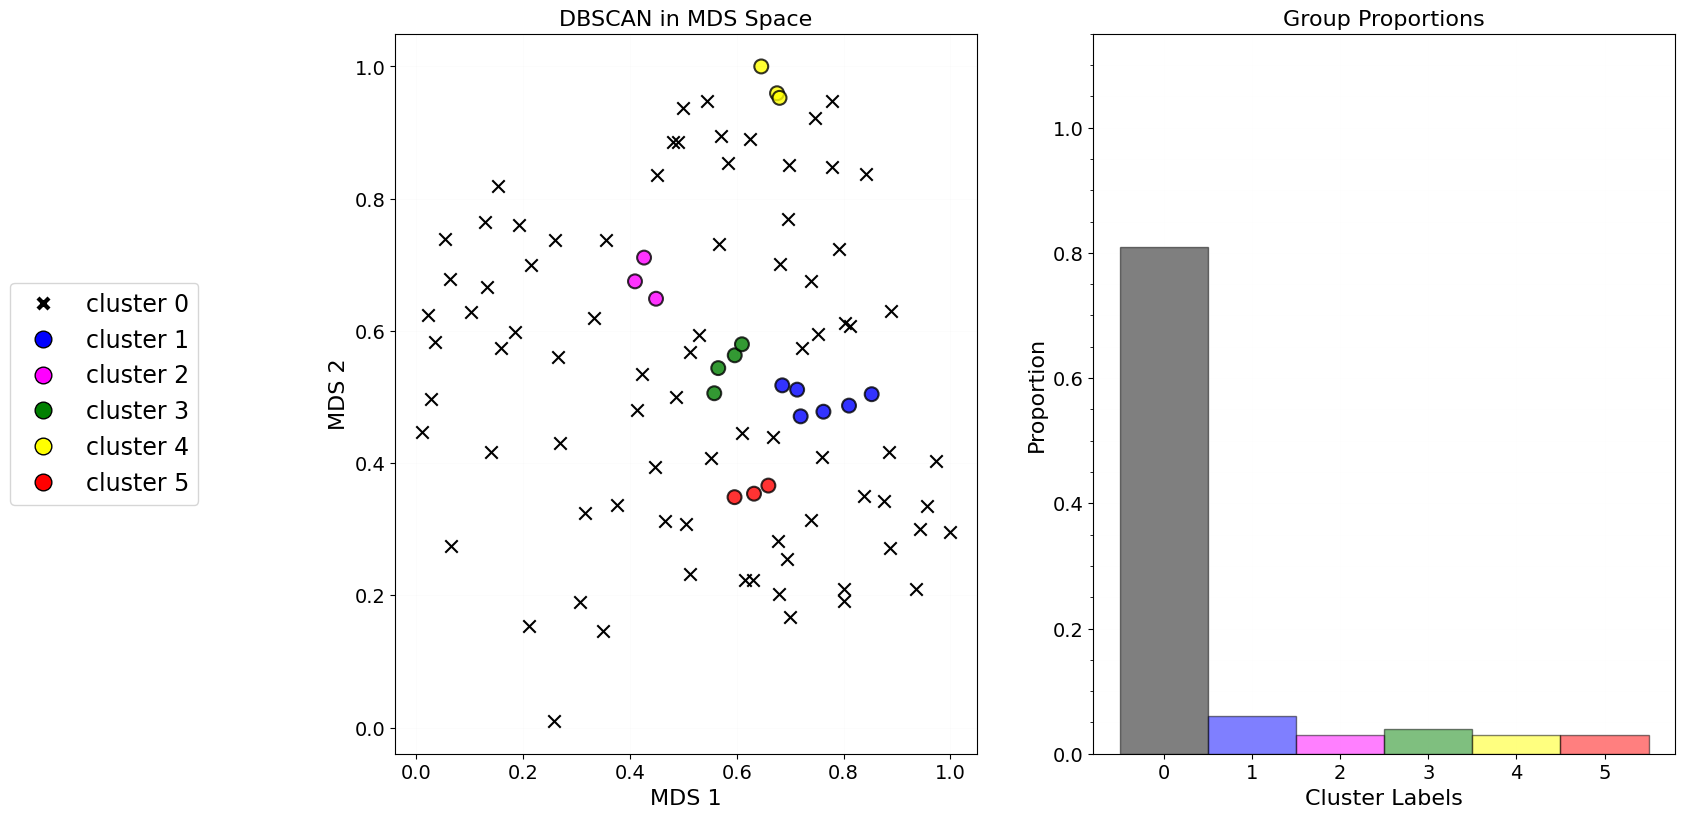

In [28]:
df_cluster_pr, df_outlier_pr, merged_df_pr, number_cluster_pr = proposed_routine.dbscan_plotter(
    eps=lag_distance,
    min_samp=3,
    cluster_label='DB-label',
    xlabel='NS_MDS 1',
    ylabel='NS_MDS 2',
    space_index=3,
    palette_=1,
    workflow='proposed',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

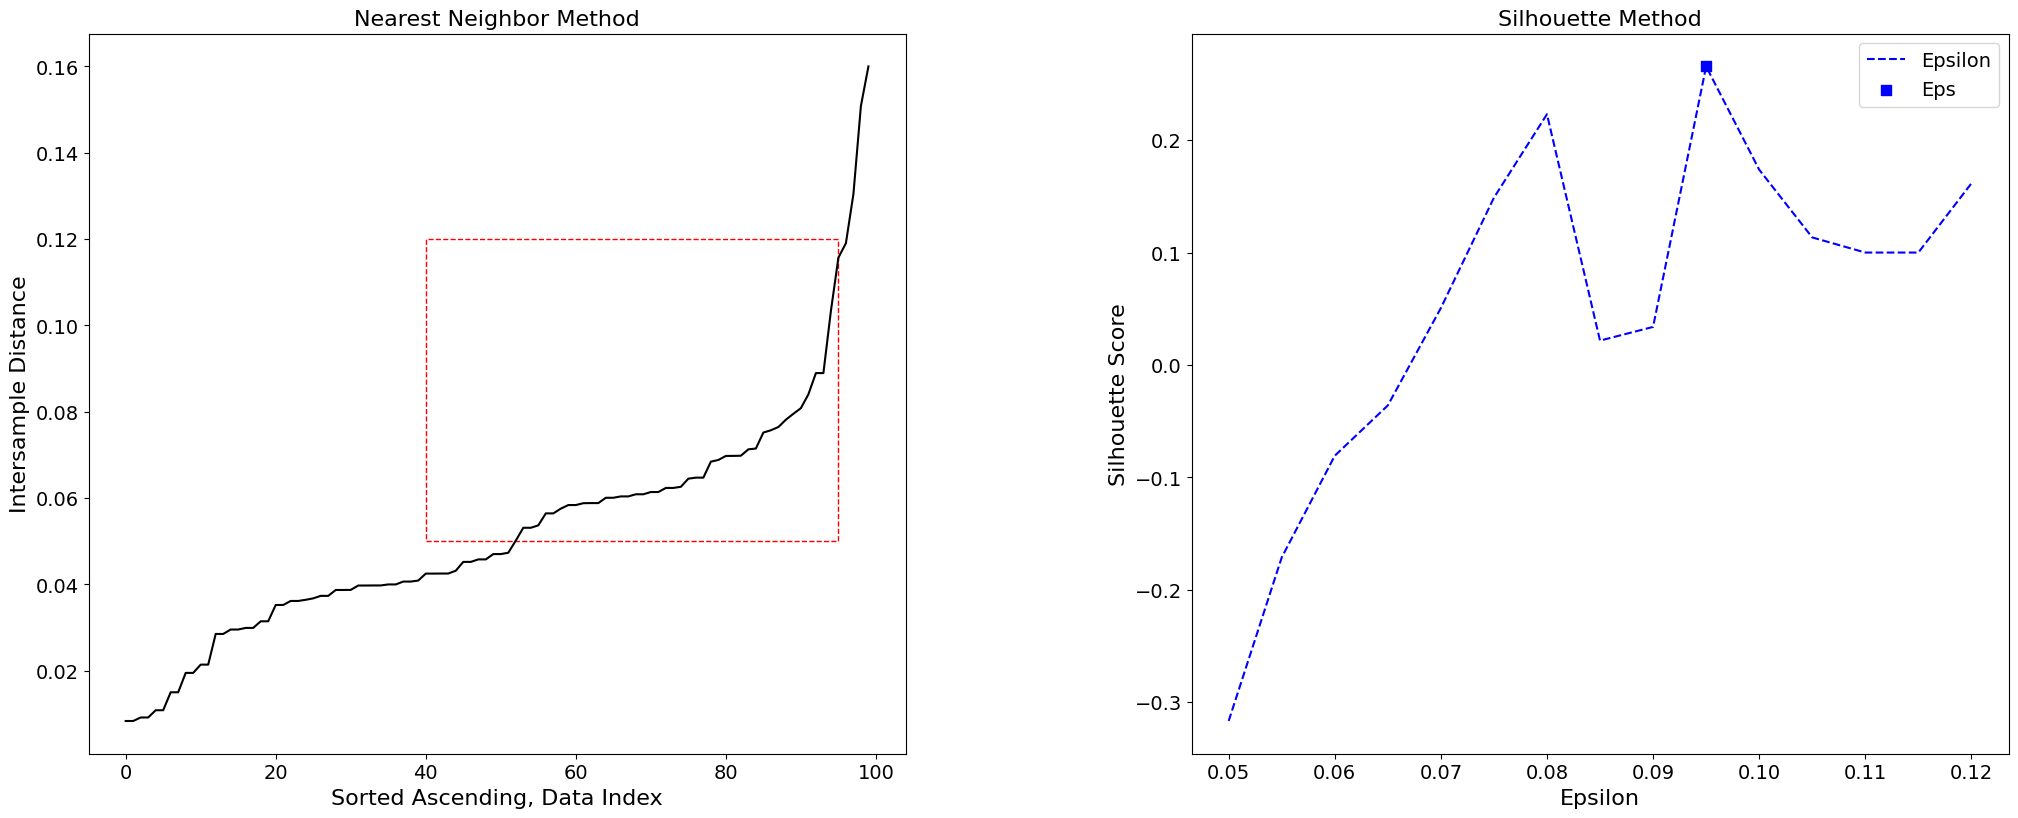

In [29]:
eps_pr , eps_silhouette_pr , min_samples_pr , min_samples2_pr , min_samples_silhouette_pr = proposed_routine.dbscan_tuner(
    min_samp=3,
    start= 0.05,
    stop= 0.12,
    step= 0.005,
    x= 40,
    y= 0.05,
    x_ext= 55,
    y_ext=0.07
)

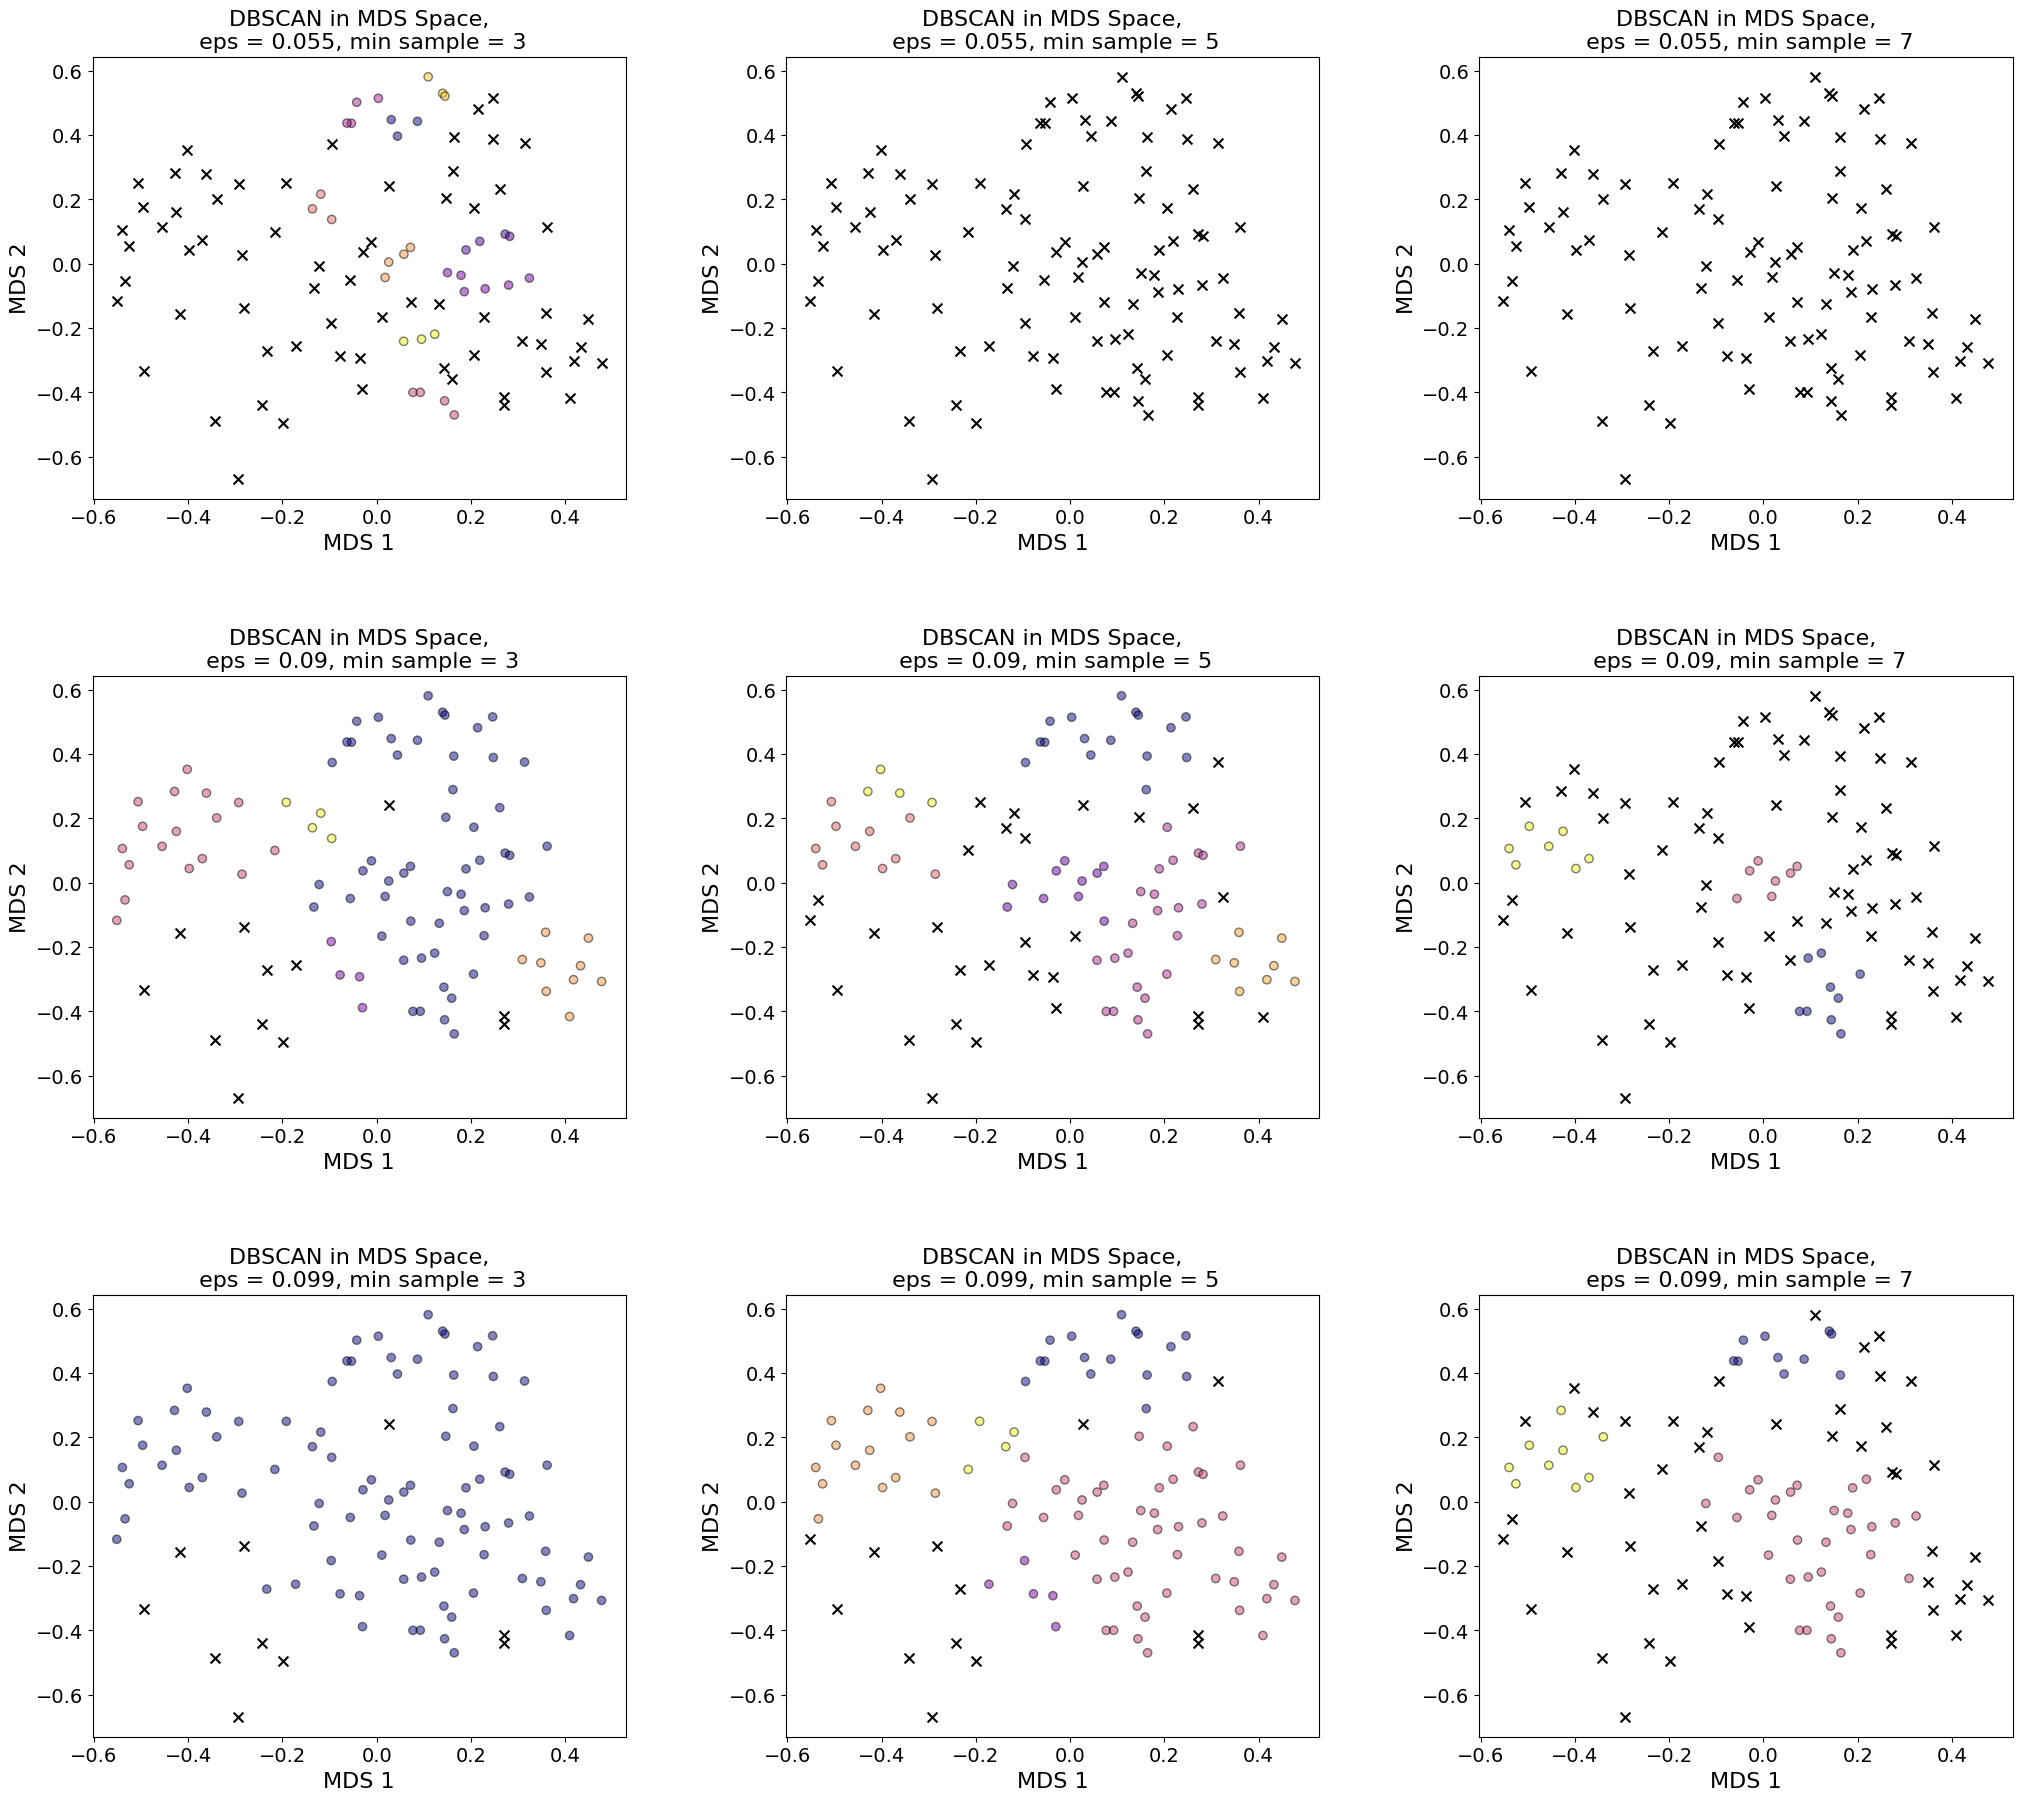

Number of unique clusters in each subplot realization [9, 0, 0, 5, 6, 3, 1, 5, 3]


In [30]:
df_arranged_proposed = df_proposed.loc[:,['MDS 1', 'MDS 2', 'NS_MDS 1', 'NS_MDS 2']]

cluster_no_proposed = proposed_routine.dbscan_sensitivity(
    df=df_arranged_proposed,
    eps_mat=[0.055, 0.09 , 0.099],
    min_sample_mat=[3,5,7],
    cluster_label='DB-label',
    space_index=3,
    xlabel_units='m',
    ylabel_units='m'
) 

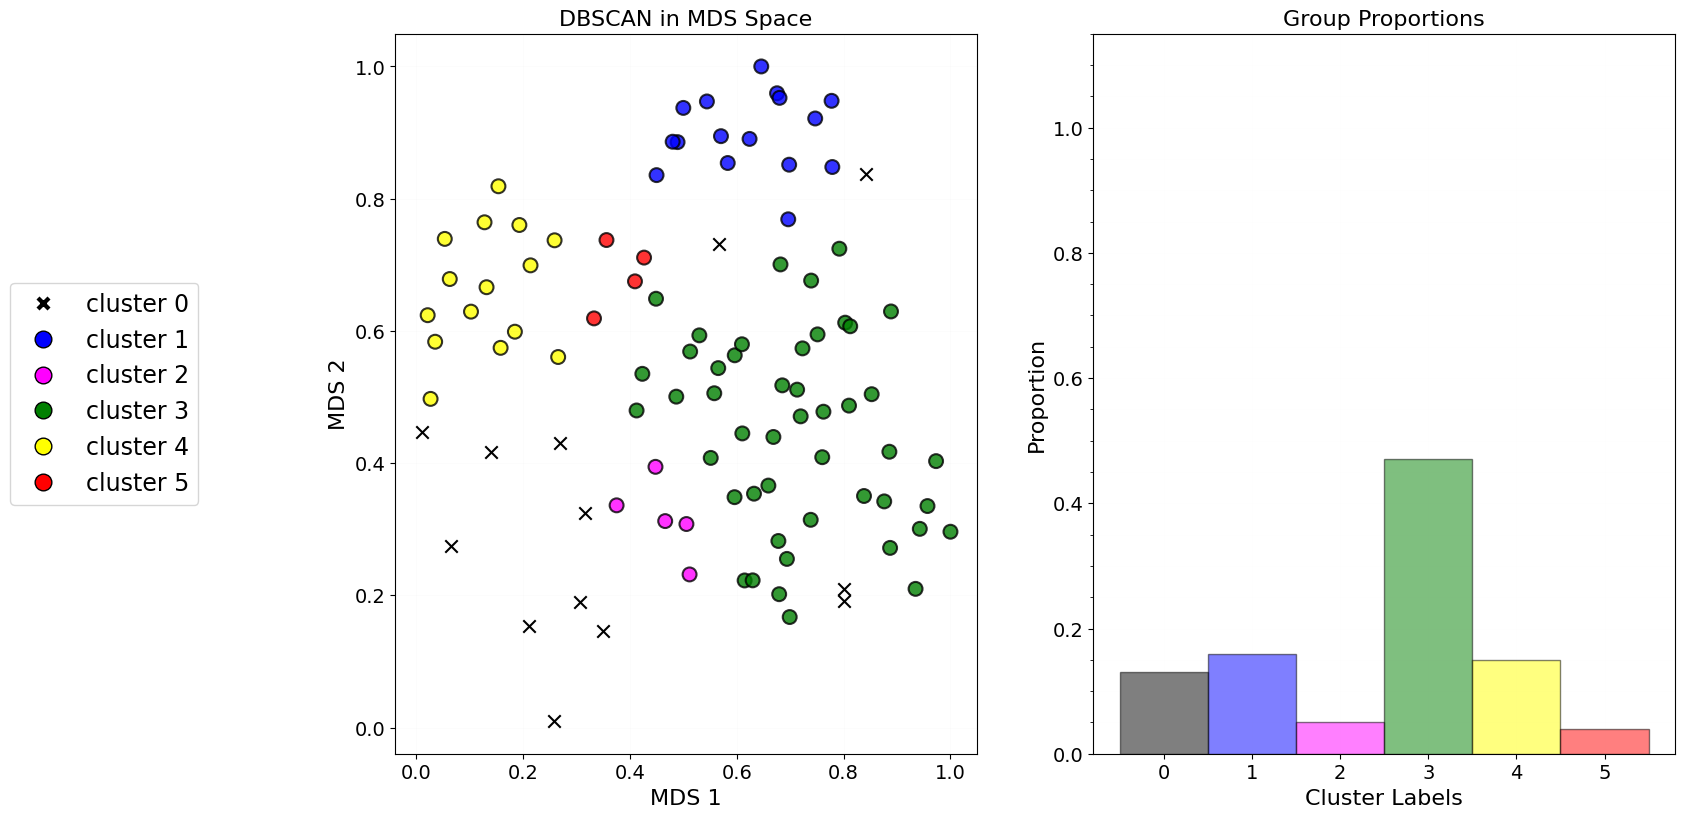

In [31]:
df_cluster_proposed, df_outlier_proposed, merged_df_proposed, number_cluster_proposed = proposed_routine.dbscan_plotter(
    eps=eps,
    min_samp=5,
    cluster_label='DB-label',
    xlabel='NS_MDS 1',
    ylabel='NS_MDS 2',
    space_index=3,
    palette_=1,
    workflow='proposed',
    test=False,
    xlabel_units='m',
    ylabel_units='m'
)

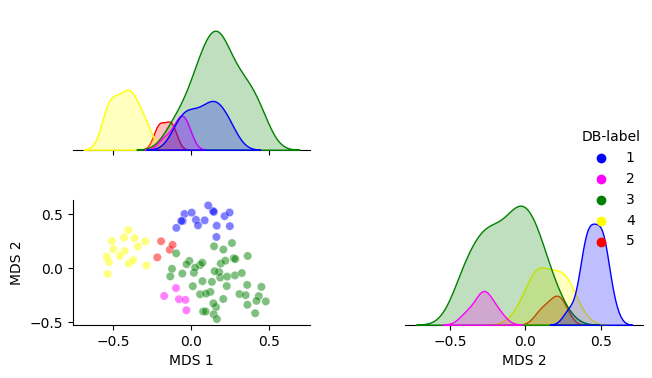

In [32]:
# For main clusters 
df_tuned_proposed = df_cluster_proposed.copy(deep=True)

matrix_scatter(
    dataframe=df_tuned_proposed,
    feat_title=['MDS 1','MDS 2'],
    left_adj=0.,
    bottom_adj=0.,
    right_adj=1.,
    top_adj=0.6,
    wspace=0.4,
    hspace=0.4,
    title='Matrix Scatterplot by Cluster in MDS Space',
    palette_=1, 
    hue_='DB-label'
)

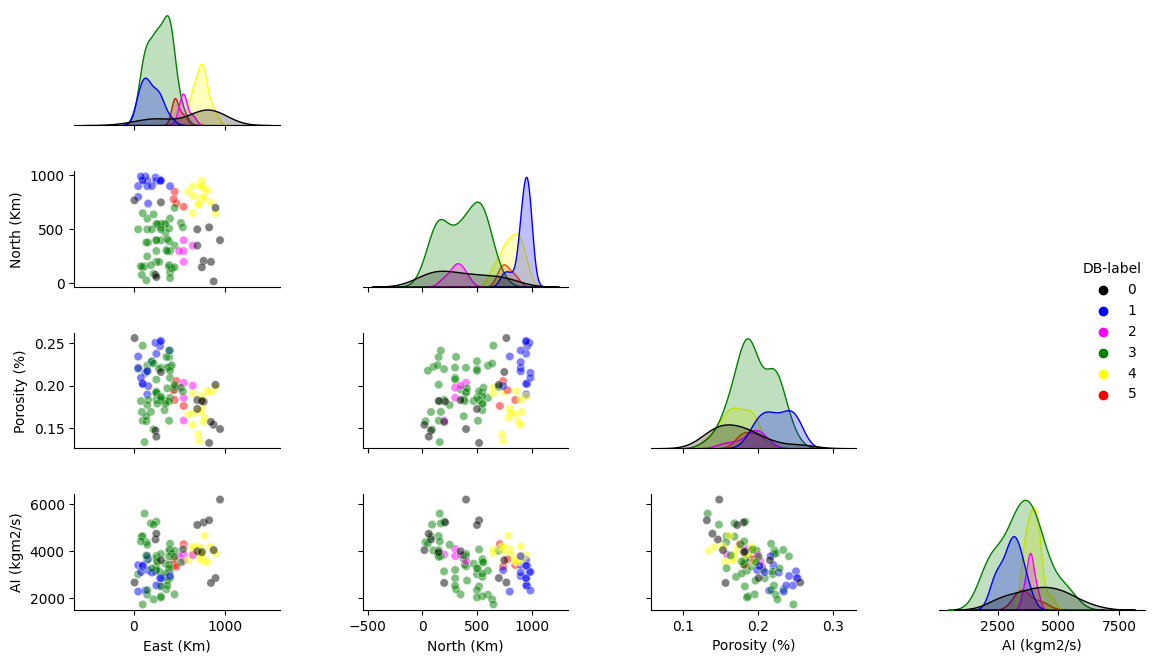

In [33]:
merged_df_proposed.rename(columns={'X': 'East (Km)','Y': 'North (Km)',
                       'Porosity': 'Porosity (%)','AI': 'AI (kgm2/s)'}, inplace=True)

matrix_scatter(merged_df_proposed, ['East (Km)','North (Km)','Porosity (%)','AI (kgm2/s)'], 0., 0., 1., 0.6, 0.4, 0.4, 
                  'Matrix Scatterplot by Cluster', 1, hue_='DB-label',)

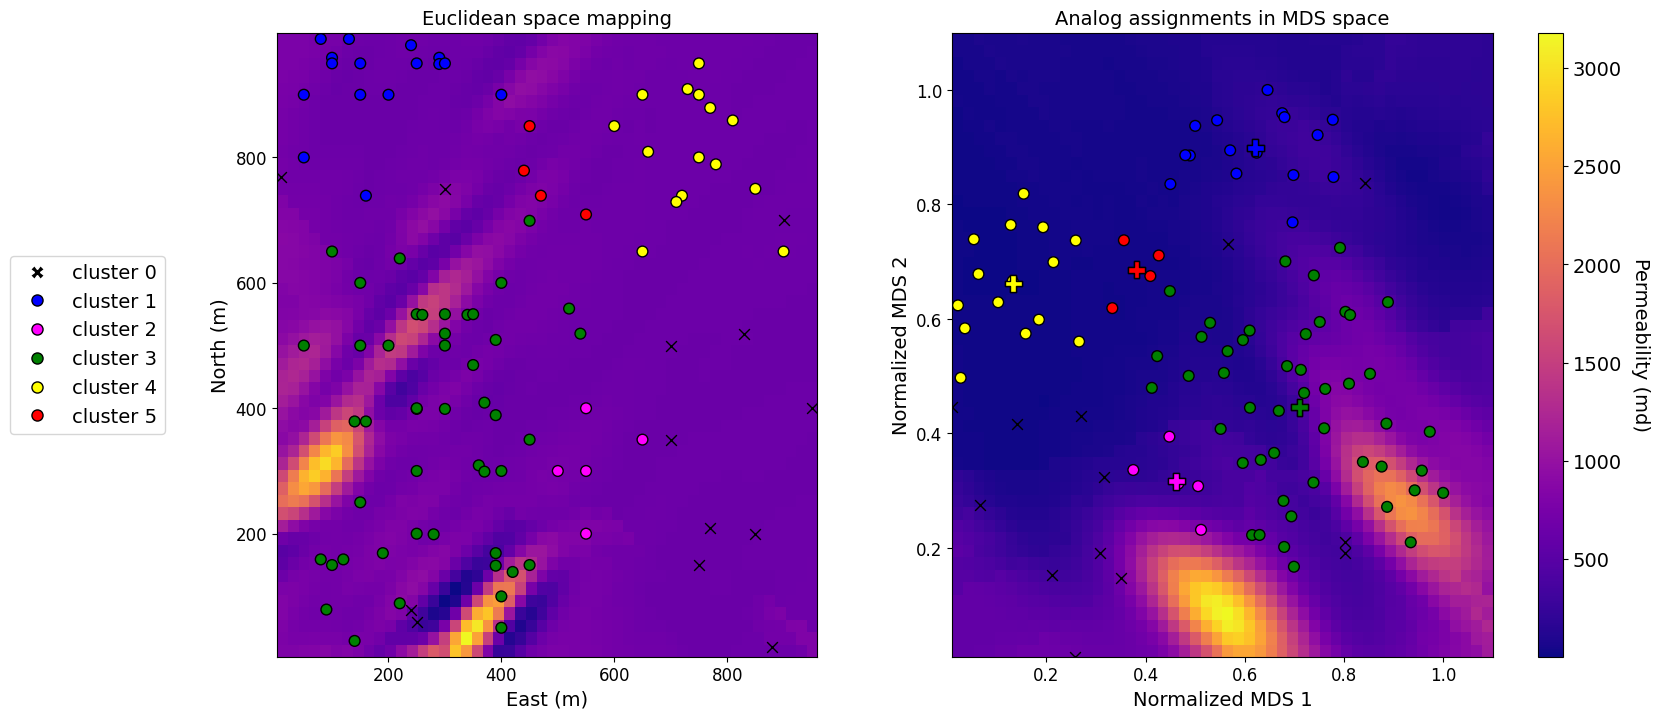

In [34]:
proposed_plots = ProcessPlots(
    df=df,
    kriging_response_euclidean=kmap_Eucl,
    kriging_response_mds=kmap_mds
)

proposed_plots.analog_maps(
    cluster=[df_cluster_proposed, df_cluster_proposed],
    outlier=[df_outlier_proposed, df_outlier_proposed],
    X=['X', 'NS_MDS 1'],
    Y=['Y', 'NS_MDS 2'],
    T=['Euclidean space mapping', 'Analog assignments in MDS space'],
    cluster_label='DB-label',
    x_labels=['East (m)', 'Normalized MDS 1'],
    y_labels=['North (m)', 'Normalized MDS 2'],
    cb_title='Permeability (md)',
    palette_=1,
    workflow='proposed',
    cmap='plasma',
    test=False,
    save=False,
    offset_eucl_x=(0.2, 1.01),
    offset_eucl_y=(0.2, 1.01),
    offset_mds_x=(1, 1.1),  # for MDS, consider negatives values present in range
    offset_mds_y=(1, 1.1)   # for MDS, consider negatives values present in range
)

In [35]:
df_GCS = gcs(dataframe=merged_df_proposed, xcol='MDS 1', ycol='MDS 2', cluster_label='DB-label')

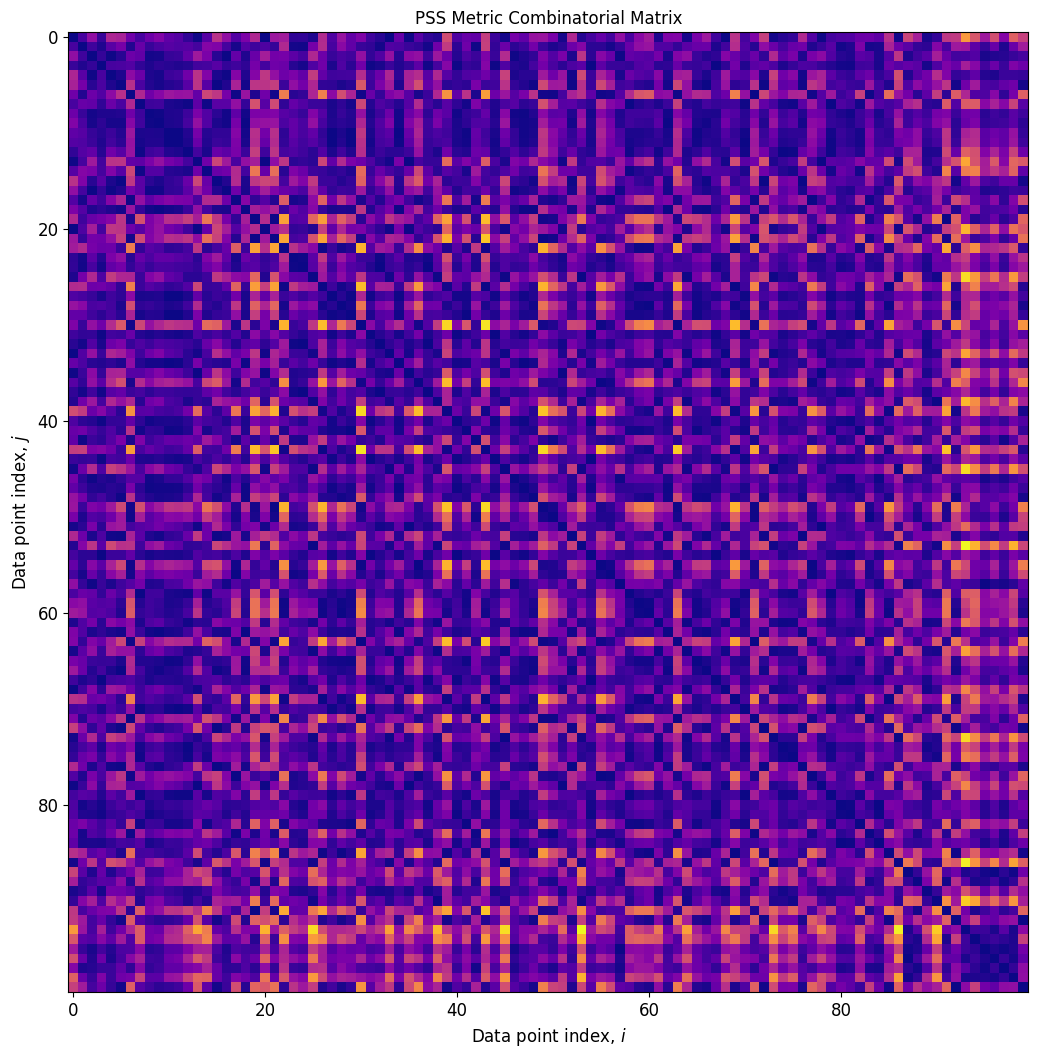

In [36]:
starts, results = pss_all(merged_df_proposed, 'MDS 1', 'MDS 2')
PSS_all = pd.DataFrame(results, columns=['PSS'])

 ## Midé Mabadeje, Graduate Research Assistant, University of Texas at Austin


Midé is a Ph.D. candidate working at the research intersection of subsurface modeling, prediction, and analytics in low dimensional spaces under uncertainty. Her research involves creating new data analytics, metrics, and statistical workflows to address various sources of spatial and/or subsurface bias to obtain representative sampling to impact decision-making.

I am open to opportunities and collaborations in related research areas and disciplines underlined with spatial statistics, data science, and machine learning. I can be reached at ademidemabadeje@austin.utexas.edu.

For more about Midé check out these links:

####  [GitHub](https://github.com/Mide478) | [GoogleScholar](https://scholar.google.com/citations?user=9nksjzQAAAAJ&hl=en&oi=ao)  | [LinkedIn](https://www.linkedin.com/in/ademidemabadeje)

<br>

## Michael Pyrcz, Professor, University of Texas at Austin
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development.

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


<br>


We hope this was helpful,

*Midé & Michael*